In [1]:
import numpy as np 

In [2]:
from model.afnonet import AFNONet

In [3]:
import os 
import torch

$$
\left(
\begin{array}{ccccccc}
 \epsilon _{\text{II}}^1-\epsilon _{\text{II}}^{\text{real}} & 0 & 0 & 0 & 0 & 0 & 0 \\
 \epsilon _{\text{III}}^2-\epsilon _{\text{III}}^{\text{real}} & \epsilon _{\text{III}}^1-\epsilon _{\text{III}}^{\text{real}} & 0 & 0 & 0 & 0 & 0 \\
 \epsilon _{\text{IV}}^3-\epsilon _{\text{IV}}^{\text{real}} & \epsilon _{\text{IV}}^2-\epsilon _{\text{IV}}^{\text{real}} & \epsilon _{\text{IV}}^1-\epsilon _{\text{IV}}^{\text{real}} & 0 & 0 & 0 & 0 \\
 \epsilon _V^4-\epsilon _V^{\text{real}} & \epsilon _V^3-\epsilon _V^{\text{real}} & \epsilon _V^2-\epsilon _V^{\text{real}} & \epsilon _V^1-\epsilon _V^{\text{real}} & 0 & 0 & 0 \\
 \epsilon _{\text{VI}}^5-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^4-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^3-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^2-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^1-\epsilon _{\text{VI}}^{\text{real}} & 0 & 0 \\
 \epsilon _{\text{VII}}^6-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^5-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^4-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^3-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^2-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^1-\epsilon _{\text{VII}}^{\text{real}} & 0 \\
 \epsilon _{\text{VIII}}^7-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^6-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^5-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^4-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^3-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^2-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^1-\epsilon _{\text{VIII}}^{\text{real}} \\
\end{array}
\right)
$$

$$ 
f (X_t)+\epsilon_I^t=\hat{X_{t+1}} + \epsilon_I^t = X_{t+1}
$$

$$
f[f(X_t)] + \epsilon_{II}^t = X_{t+2}\\
f (X_{t+1})+\epsilon_I^{t+1}=\hat{X_{t+2}} + \epsilon_I^{t+1} = X_{t+2}
$$


$$
\epsilon_{II}^t = f (X_{t+1}) - f[f(X_t)]  +\epsilon_I^{t+1} = f (X_{t+1}) - f[\hat{X_{t+1}}]+\epsilon_I^{t+1}
$$

$$
\epsilon_{II}^t = \nabla f|_{X_{t+1}} [X_{t+1}-\hat{X_{t+1}}]+\epsilon_I^{t+1} =  \nabla f|_{X_{t+1}} \epsilon_I^{t} +\epsilon_I^{t+1}
$$

##### load alpha

In [4]:
import numpy as np

In [5]:
def get_list_of_N(N):
    _list = []
    for i in range(N):
        start = i
        temp  = [start]
        if i>0:
            for j in range(i):
                temp.append(start+N-1-j)  
                start = start+N-1-j
        temp.reverse()
        _list+=temp
    return _list

In [6]:
map_total_num_to_N    = {}
map_total_num_to_list = {}
for N in range(6,22):
    _list = get_list_of_N(N)
    map_total_num_to_N[len(_list)] = N
    map_total_num_to_list[len(_list)] = _list

In [7]:
def get_error_propagation(fourcastresult):
#     error_order7 = torch.LongTensor([  0,
#                                        7, 1,
#                                       13, 8, 2,
#                                       18,14, 9, 3,
#                                       22,19,15,10,4,
#                                       25,23,20,16,11,5,
#                                       27,26,24,21,17,12,6])
#     error_order6 = torch.LongTensor([ 0,
#                                       6, 1,
#                                      11, 7, 2,
#                                      15,12, 8, 3,
#                                      18,16,13, 9,4,
#                                      20,19,17,14,10,5
#                                     ])
    idxkeys=[t for t in fourcastresult.keys() if isinstance(t,int)]
    idxkeys.sort()
    out={}
    for key in ['error_record','real_res_error_record', 
                'real_appx_delta_record','appx_res_error_record'
               ]:
        b = []
        if key not in fourcastresult[0]:continue
        total_length = len(fourcastresult[0][key])
        N=map_total_num_to_N[total_length];
        x,y = torch.tril_indices(N,N)
        error_order = map_total_num_to_list[total_length]
        for i in idxkeys:
            a = torch.zeros(N,N,70)
            a[x,y] = fourcastresult[i][key][error_order]
            b.append(a)
        b = torch.stack(b)
        out[key] = b
    for key in ['real_res_angle_record',
                'appx_res_angle_record'
               ]:
        b = []
        if key not in fourcastresult[0]:continue
        total_length = len(fourcastresult[0][key])
        N=map_total_num_to_N[total_length];
        x,y = torch.tril_indices(N,N)
        error_order = map_total_num_to_list[total_length]
        for i in idxkeys:
            a = torch.zeros(N,N)
            a[x,y] = fourcastresult[i][key][error_order]
            b.append(a)
        b = torch.stack(b)
        out[key] = b
    
    for key in ['error_record_snap','real_res_error_record_snap', ]:
        b = []      
        if key not in fourcastresult[0]:continue
        total_length = len(fourcastresult[0][key])
        #print(fourcastresult[0][key].shape)
        N   = map_total_num_to_N[total_length];
        x,y = torch.tril_indices(N,N)
        error_order = map_total_num_to_list[total_length]
        for i in idxkeys:
            a = torch.zeros(N,N,5,6,6)
            a[x,y] = fourcastresult[i][key][error_order]
            b.append(a)
        b = torch.stack(b)
        out[key] = b
        
        
#     for key in ['abs_error', 'est_error', 'Jacobianv', 'JacobV_N','abc_error']:
#         b = []
#         for i in range(len(fourcastresult)-10):
#             a = torch.zeros(N,N)
#             a[x,y] = fourcastresult[i][key][error_order]
#             if key != 'JacobV_N':a=a/fourcastresult[i]['blevel_v'].mean(1)[1:,None]
#             b.append(a)
#         b = torch.stack(b)
#         out[key] = b
    
#     for key in ['Angle']:
#         b = []
#         for i in range(len(fourcastresult)-10):
#             a = torch.zeros(N,N)
#             a[x,y] = fourcastresult[i][key][error_order]
#             b.append(a)
#         b = torch.stack(b)
#         out[key] = b
        
#     for key in ['alevel_v','blevel_v','JacobVA_N']:
#         b = []
#         for i in range(len(fourcastresult)-10):
#             b.append(fourcastresult[i][key])
#         b = torch.stack(b)
#         out[key] = b
    return out

In [8]:
def get_fourcastresult(fourcastresult):
    #fourcastresult="checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_06_12_22-seed_73001"
    ROOT= fourcastresult
    fourcastresult_list = [os.path.join(ROOT,p) for p in os.listdir(fourcastresult) if 'fourcastresult.gpu' in p]
    fourcastresult={}

    for save_path in fourcastresult_list:
        tmp = torch.load(save_path)
        for key,val in tmp.items():
            if key not in fourcastresult:
                fourcastresult[key] = val
            else:
                if key == 'global_rmse_map':
                    fourcastresult['global_rmse_map'] = [a+b for a,b in zip(fourcastresult['global_rmse_map'],tmp['global_rmse_map'])]
                else:
                    fourcastresult[key] = val # overwrite
    return fourcastresult

In [9]:
# fourcastresult_pretrain="checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_06_12_22-seed_73001"
# fourcastresult_pretrain = get_fourcastresult(fourcastresult_pretrain)
# # torch.save(fourcastresult_pretrain,fourcastresult+"/fourcastresult.mid_tangent.pt")
# fourcastresult_finetune="checkpoints/WeathBench7066/AFNONet/ts_3_finetune-2D706N_per_1_step/01_09_02_41_31-seed_73001"
# fourcastresult_finetune = get_fourcastresult(fourcastresult_finetune)
# #torch.save(fourcastresult_finetune,fourcastresult+"/fourcastresult.right_tangent.pt")

In [9]:
fwd1times_sketch      = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_26_14_21_64252-seed_73001"))
fwd2times_pretrain    = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_3_finetune-2D706N_per_1_step/01_26_17_38_64254-seed_73001"))
fwd2times_sketch      = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_3_pretrain-2D706N_per_1_step/01_26_23_35_64256-seed_73001"))
fwd3times_pretrain    = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_4_finetune-2D706N_per_1_step/01_26_23_56_64255-seed_73001"))
fwd3times_sketch      = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_4_pretrain-2D706N_per_1_step/01_26_17_38_64248-seed_73001"))
fwd2times_log_pretrain= get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_3_finetune-2D706N_per_1_step/02_18_20_50_50161-seed_73001"))
fwd5times_pretrain    = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_6_finetune-2D706N_per_1_step/02_15_14_25_54834-seed_73001"))
fwd4times_pre_000001  = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_4_finetune-2D706N_per_1_step/02_07_02_16_40837-seed_73001"))

In [10]:
fwd2times_pretrain    = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_3_finetune-2D706N_per_1_step/01_26_17_38_64254-seed_73001"))

In [15]:
fwd2times_pretrain.keys()

dict_keys(['error_record', 'real_res_error_record', 'real_res_angle_record', 'error_record_snap', 'real_res_error_record_snap'])

In [18]:
from mltool.visualization import *

In [25]:
data.shape

torch.Size([1444, 14])

In [31]:
mean

array([10.9514065, 12.222465 , 15.267995 , 12.389636 , 18.061935 ,
       27.721241 , 22.597544 , 21.328121 , 17.769575 , 19.982132 ,
       26.672852 , 21.256485 , 19.042795 , 23.03216  ], dtype=float32)

In [37]:
tdata['error_record_snap'][:,:-1,0,0,0,0][4]

tensor([5.9605e-04, 1.3805e-02, 1.4516e-02, 2.2654e-02, 2.7077e-02, 1.1901e-02,
        3.1168e-02, 1.6350e-02, 2.8956e-02, 2.6562e-01, 1.0727e-01, 9.4298e-03,
        2.4201e-03, 1.6585e-04])

In [42]:
np.where(np.isinf(data))

(array([  32,  364,  492,  512,  578,  661,  715,  774,  797,  896, 1006,
        1062, 1159, 1216, 1222, 1269, 1322, 1333, 1406]),
 array([12,  0,  3,  7, 12, 10,  5,  7, 13, 12,  6, 12, 10,  1,  7,  7,  5,
         0,  0]))

In [51]:
real_res_error_record_snap[32].double()

tensor([3.9752e-01, 8.4306e-01, 1.1608e+01, 8.8197e-01, 1.8904e-03, 2.8925e-01,
        5.0883e+00, 1.7185e+00, 1.3849e+00, 3.1956e+00, 1.3697e+00, 1.2664e-01,
               inf, 2.6075e-01], dtype=torch.float64)

In [52]:
error_record_snap[32]

tensor([0.0089, 0.0115, 0.0030, 0.0386, 0.0247, 0.0844, 0.0041, 0.0343, 0.1053,
        0.0190, 0.0546, 0.0047, 0.0000, 0.0132])

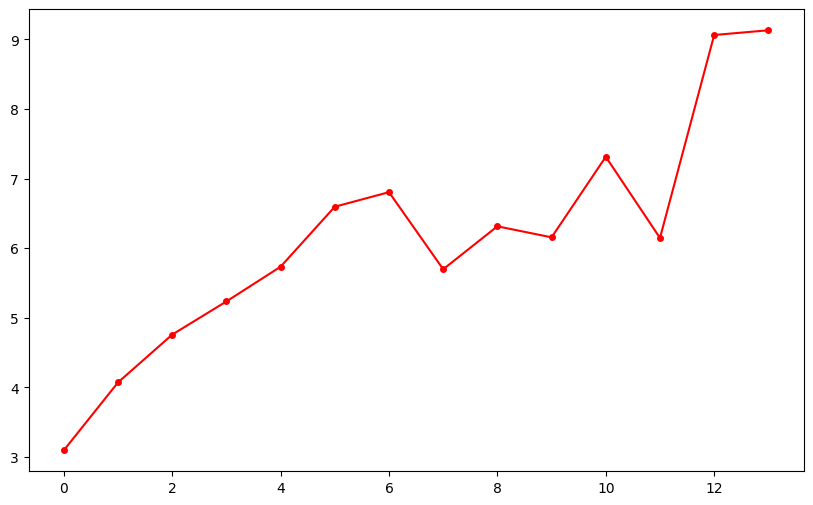

In [62]:
%matplotlib inline
tdata = fwd2times_pretrain
colorlist=['r','g','b','olive','black','purple','magenta','orange']
level = 0
fig,ax = plt.subplots(figsize=(10,6))
#for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
name = "111"
offset=0
p = 3
w = 2
h = 4

real_res_error_record_snap = tdata['real_res_error_record_snap'][:,:,0,p,w,h]
error_record_snap          = tdata['error_record_snap'][:,:-1,0,p,w,h]
data = real_res_error_record_snap/(error_record_snap + 1e-5)
#data = error_record_snap
mean = data.mean(0).numpy()
x_axis = np.arange(len(mean))
ax.plot(x_axis, mean,label=name,marker='o',markersize=4,color = colorlist[offset])
# if mode=="geometric_first":
#     def func(x, a, b):return 1 - (1-a) * (b**x)
#     a = mean[0]
#     b = (1-mean[1])/(1-mean[0])
#     print(f"a={a},b={b}")
#     ax.plot(x_axis, func(x_axis,a,b),color = colorlist[offset])
# elif "fit" in mode:
#     if "geometric_fit" in mode:
#         def func(x, a, b):return 1 - (1-a) * (b**x)
#     elif "tanh" in mode:
#         def func(x, a, b):return np.tanh(a*x-b)
#     xdata= x_axis = np.arange(len(mean))
#     ydata = mean
#     popt, pcov = curve_fit(func, xdata, ydata)
#     print(f"popt={popt}")
#     ax.plot(x_axis, func(x_axis,*popt),color = colorlist[offset])

# plt.legend(prop={'size': 14},loc="lower right")    
# x_axis = np.arange(19)
# ax.plot(x_axis, [1]*len(x_axis),color = "gray")
# ax.set_xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=16)
# ax.set_yticks(np.arange(4,11)*0.1,fontsize=20)
# ax.set_ylim(0.32, 1.05)
# ax.text(.2,.8,r"$\alpha^N=E[\frac{||\epsilon_{t+"+f"n"+"}^{"+f"N"+r"} - \epsilon_{t+"+f"n"+"}^I||}{||\epsilon_{t+"+f"n-1"+"}^{"+f"N-1"+r"}||}]$",
#          horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

In [12]:
fwd2times_pretrain['real_res_error_record_snap'].shape

torch.Size([1444, 14, 14, 5, 6, 6])

In [19]:
from mltool.visualization import *

In [13]:
_component_list= ([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,  1]+ # u component of wind and the 10m u wind
                    [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,  2]+   # v component of wind and the 10m v wind
                    [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  0]+   # Temperature and the 2m_temperature
                    [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18]+   # Geopotential and the last one is ground Geopotential, should be replace later
                    [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 57]    # Realitve humidity and the Realitve humidity at groud, should be modified by total precipitaiton later
                    )
single_vnames = ["2m_temperature",
                  "10m_u_component_of_wind",
                  "10m_v_component_of_wind",
                  "total_cloud_cover",
                  "total_precipitation",
                  "toa_incident_solar_radiation"]
level_vnames= []
for physics_name in ["geopotential", "temperature",
                     "specific_humidity","relative_humidity",
                     "u_component_of_wind","v_component_of_wind",
                     "vorticity","potential_vorticity"]:
    for pressure_level in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]:
        level_vnames.append(f"{pressure_level}hPa_{physics_name}")
all_vnames = single_vnames + level_vnames
vnames= np.array([all_vnames[i] for i in _component_list])
vnames[14*4-1] = 'pad1'
vnames[-1]='pad2'

In [14]:
data_list = [
fwd1times_sketch  ,
fwd2times_sketch  ,
fwd2times_pretrain,
fwd3times_sketch  ,
fwd3times_pretrain, 
fwd5times_pretrain,
fwd2times_log_pretrain,  
]
name_list = [
"S:M:T+1"  ,
"S:M:T+2"  ,
"P:M:T+2",
"S:M:T+3"  ,
"P:M:T+3",
"P:M:T+5",
"P:L:T+2",
]

NameError: name 'fwd1times_sketch' is not defined

In [12]:
upsign = ['I','II','III','IV','V','VI','VII','VIII']

In [63]:
pool={
    "des": {
       
        "value": "Exp"
    },
    "gpu": {
       
        "value": 0
    },
    "itr": {
       
        "value": 1
    },
    "d_ff": {
       
        "value": 2048
    },
    "data": {
       
        "value": "ETTm2"
    },
    "freq": {
       
        "value": "h"
    },
    "loss": {
       
        "value": "MSE"
    },
    "mode": {
       
        "value": "finetune"
    },
    "rank": {
       
        "value": 0
    },
    "seed": {
       
        "value": 2021
    },
    "c_out": {
       
        "value": 7
    },
    "debug": {
       
        "value": False
    },
    "embed": {
       
        "value": "timeF"
    },
    "lradj": {
       
        "value": "type1"
    },
    "model": {
       
        "value": "Crossformer"
    },
    "top_k": {
       
        "value": 5
    },
    "_wandb": {
       
        "value": {
            "t": {
                "1": [
                    1,
                    5,
                    53,
                    55
                ],
                "2": [
                    1,
                    5,
                    53,
                    55
                ],
                "3": [
                    2,
                    13,
                    16,
                    23
                ],
                "4": "3.9.13",
                "5": "0.13.5",
                "8": [
                    5
                ]
            },
            "code_path": "code/test.py",
            "framework": "torch",
            "start_time": 1680032123.380944,
            "cli_version": "0.13.5",
            "is_jupyter_run": False,
            "python_version": "3.9.13",
            "is_kaggle_kernel": False
        }
    },
    "dec_in": {
       
        "value": 7
    },
    "distil": {
       
        "value": True
    },
    "enc_in": {
       
        "value": 7
    },
    "factor": {
       
        "value": 1
    },
    "target": {
       
        "value": "OT"
    },
    "d_model": {
       
        "value": 512
    },
    "devices": {
       
        "value": "0,1,2,3"
    },
    "dropout": {
       
        "value": 0.1
    },
    "n_heads": {
       
        "value": 8
    },
    "seq_len": {
       
        "value": 96
    },
    "setting": {
       
        "value": "TSL-ETTm2/Crossformer/TTM.96_48_96/bs_32fwd2_D/03_29_03_35_18-seed_2021"
    },
    "use_amp": {
       
        "value": False
    },
    "use_gpu": {
       
        "value": True
    },
    "d_layers": {
       
        "value": 1
    },
    "dist_url": {
       
        "value": "tcp://127.0.0.1:54247"
    },
    "e_layers": {
       
        "value": 2
    },
    "features": {
       
        "value": "M"
    },
    "model_id": {
       
        "value": "ETTm2_96_96"
    },
    "patience": {
       
        "value": 3
    },
    "pred_len": {
       
        "value": 96
    },
    "SAVE_PATH": {
       
        "value": "./checkpoints/TSL-ETTm2/Crossformer/TTM.96_48_96/bs_32fwd2_D/03_29_03_35_18-seed_2021"
    },
    "data_path": {
       
        "value": "ETTm2.csv"
    },
    "dist_file": {
       
        "value": None
    },
    "label_len": {
       
        "value": 48
    },
    "mask_rate": {
       
        "value": 0.25
    },
    "root_path": {
       
        "value": "./dataset/ETT-small/"
    },
    "task_name": {
       
        "value": "long_term_forecast"
    },
    "time_step": {
       
        "value": 3
    },
    "train_set": {
       
        "value": "large"
    },
    "use_wandb": {
       
        "value": "wandb_runtime"
    },
    "activation": {
       
        "value": "gelu"
    },
    "batch_size": {
       
        "value": 32
    },
    "local_rank": {
       
        "value": 0
    },
    "moving_avg": {
       
        "value": 25
    },
    "trace_freq": {
       
        "value": 100
    },
    "world_size": {
       
        "value": 1
    },
    "checkpoints": {
       
        "value": "./checkpoints/"
    },
    "config_file": {
       
        "value": None
    },
    "distributed": {
       
        "value": False
    },
    "is_training": {
       
        "value": 1
    },
    "num_kernels": {
       
        "value": 6
    },
    "num_workers": {
       
        "value": 10
    },
    "weight_name": {
       
        "value": None
    },
    "dist_backend": {
       
        "value": "nccl"
    },
    "train_epochs": {
       
        "value": 10
    },
    "anomaly_ratio": {
       
        "value": 0.25
    },
    "do_early_stop": {
       
        "value": 1
    },
    "fourcast_step": {
       
        "value": 10
    },
    "learning_rate": {
       
        "value": 0.00001
    },
    "p_hidden_dims": {
       
        "value": [
            128,
            128
        ]
    },
    "use_multi_gpu": {
       
        "value": False
    },
    "ngpus_per_node": {
       
        "value": 1
    },
    "activate_stamps": {
       
        "value": [
            [
                1
            ],
            [
                2
            ]
        ]
    },
    "p_hidden_layers": {
       
        "value": 2
    },
    "pretrain_weight": {
       
        "value": "checkpoints/TSL-ETTm2/Crossformer/ftM.96_48_96/bs_32/03_23_19_01_42-seed_2021/checkpoint.pth"
    },
    "output_attention": {
       
        "value": False
    },
    "valid_batch_size": {
       
        "value": 64
    },
    "compute_graph_set": {
       
        "value": "fwd2_D"
    },
    "seasonal_patterns": {
       
        "value": "Monthly"
    },
    "accumulation_steps": {
       
        "value": 1
    },
    "activate_error_coef": {
       
        "value": [
            [
                0,
                1,
                1,
                1,
                "quantity"
            ],
            [
                0,
                2,
                2,
                1,
                "quantity"
            ]
        ]
    },
    "multiprocessing_distributed": {
       
        "value": False
    },
    "directly_esitimate_longterm_error": {
       
        "value": 0
    }
}

In [67]:
import json
json.dumps(dict([(key,val['value']) for key, val in pool.items() if key[0]!="_"]))

'{"des": "Exp", "gpu": 0, "itr": 1, "d_ff": 2048, "data": "ETTm2", "freq": "h", "loss": "MSE", "mode": "finetune", "rank": 0, "seed": 2021, "c_out": 7, "debug": false, "embed": "timeF", "lradj": "type1", "model": "Crossformer", "top_k": 5, "dec_in": 7, "distil": true, "enc_in": 7, "factor": 1, "target": "OT", "d_model": 512, "devices": "0,1,2,3", "dropout": 0.1, "n_heads": 8, "seq_len": 96, "setting": "TSL-ETTm2/Crossformer/TTM.96_48_96/bs_32fwd2_D/03_29_03_35_18-seed_2021", "use_amp": false, "use_gpu": true, "d_layers": 1, "dist_url": "tcp://127.0.0.1:54247", "e_layers": 2, "features": "M", "model_id": "ETTm2_96_96", "patience": 3, "pred_len": 96, "SAVE_PATH": "./checkpoints/TSL-ETTm2/Crossformer/TTM.96_48_96/bs_32fwd2_D/03_29_03_35_18-seed_2021", "data_path": "ETTm2.csv", "dist_file": null, "label_len": 48, "mask_rate": 0.25, "root_path": "./dataset/ETT-small/", "task_name": "long_term_forecast", "time_step": 3, "train_set": "large", "use_wandb": "wandb_runtime", "activation": "gelu"

### plot

##### feature plot

In [26]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')
# error_matrix      = data_list[4]['error_record']
# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))

# with plt.style.context(['science', 'no-latex', 'nature']):
#     for level in range(7):
#         data = error_matrix[:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=r"$||\epsilon^"+f"{level}"+r"||$")
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,'fwd3times_pretrain',horizontalalignment='center',
#             transform=ax.transAxes,fontdict={'size':30})

In [135]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level=4
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for name,tdata in zip(name_list,data_list):
#         data = tdata['error_record'][:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,r"$|| \epsilon^{"+f"{upsign[level]}"+r"} ||$",horizontalalignment='center',transform=ax.transAxes,fontdict={'size':30})

In [137]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')
# dataidx = 4
# error_matrix      = data_list[dataidx]['real_res_error_record']
# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# upsign = ['I','II','III','IV','V','VI','VII','VIII']
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for level in range(6):
#         data = error_matrix[:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,
#                      label=r"$||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+2]}"+r"} - \epsilon_{t+"+f"{level+2}"+"}^I||$ = $||M \epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||$"
#                     )
#         plt.legend(prop={'size': 12})
# #        plt.xticks(x_axis,vnames,rotation = 90) 
#         ax = plt.gca()
#         plt.text(.5,.9,name_list[dataidx],horizontalalignment='center',
#             transform=ax.transAxes,fontdict={'size':13})

In [139]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level = 5
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for name,tdata in zip(name_list,data_list):
#         data = tdata['real_res_error_record'][:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,r"$||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+2]}"+r"} - \epsilon_{t+"+f"{level+2}"+"}^I||$ = $||M \epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||$",
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':14})

In [141]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for name,tdata in zip(name_list,data_list):
#         data = tdata['real_res_error_record'][:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,r" $||J|_{(\frac{1}{2}X_{t+"+f"{level+2}"+"}^O + \\frac{1}{2}X_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"})}\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||$",
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':14})

In [27]:
# %matplotlib inline
# colorlist=['r','g','b','pink','black','purple','olive']
# import scienceplots
# plt.style.use('science')
# with plt.style.context(['science', 'no-latex', 'nature']):
#     fig, axes = plt.subplots(5, 1,figsize=(10,6))
#     axes=axes.flatten()
#     level=0
#     for num,(ax,name,tdata) in enumerate(zip(axes,name_list,data_list)):
#         for level in range(6):
#             data = tdata['appx_res_error_record'][:,level,0]
#             mean = data.mean(0)
#             std  = data.std(0)
#             x_axis = np.arange(len(mean))
#             #plt.errorbar(x_axis, mean, yerr = std,label=name)
#             ax.plot(x_axis, mean, label=name+'_real',color = colorlist[level])
#             data = tdata['real_res_error_record'][:,level,0]
#             mean = data.mean(0)
#             std  = data.std(0)
#             x_axis = np.arange(len(mean))
#             ax.plot(x_axis, mean, label=name+'_appx',linestyle = ':',color = colorlist[level])
#         ax.set_ylim([0,0.08])
#         ax.set_xticklabels([])
#         ax.text(.5,.7,name,horizontalalignment='center',transform=ax.transAxes,fontdict={'size':10})
#         #ax.set_yticklabels([])
#         #ax.set_yscale('log')
#         if num == 0:ax.set_title("Error_Approx_Via_Jacobian",fontsize=20)
# plt.subplots_adjust(wspace=0, hspace=0)

In [43]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level = 4
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = tdata['real_res_error_record']/(tdata['error_record'][:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.legend(prop={'size': 14})
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         ax = plt.gca()
#         plt.text(.5,.9,r"$\frac{||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+2]}"+r"} - \epsilon_{t+"+f"{level+2}"+"}^I||}{||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||}$",
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

##### error plot

In [226]:
def estimate_longterm_error_from_short_term_error(alpha_list, start=1, length=20):

    valuelist2= [start]
    for alpha in alpha_list:
        valuelist2.append(start+alpha*(valuelist2[-1]))
    return valuelist2

In [225]:
def estimate_longterm_error_way_exp(e1,e2,e3, length=20):
    
    alpha0 = ( e2 - e1 )/e1
    alpha1 = ( e3 - e1 )/e2
    a = alpha0
    b = (1-alpha1)/(1-alpha0)
    def func(x, a, b):return 1 - (1-a) * (b**x)
    x_axis=np.arange(length)
    alpha_list = func(x_axis,a,b)
    valuelist2= [e1]
    for alpha in alpha_list:
        valuelist2.append(e1+alpha*(valuelist2[-1]))
    return valuelist2

def estimate_longterm_error_way_exp2(e1,e2,e3,e4, length=20):
    Delta = (-(e1*e2**2) + e2**3 + 2*e1*e2*e3 - e2**2*e3 - 2*e1*e3**2 + e2**2*e4 \
             - e2*np.sqrt((e1*(e2 - 2*e3) - e2*(e2 - 3*e3 + e4))**2 + 4*(e2**2 - e1*e3)*((e2 - e3)*(2*e3 - e4) \
             + e1*(-e3 + e4))))/(2*(e2**2 - e1*e3))
    alpha0 = -1/2*(e1*e2**2 + e2**3 - 4*e1*e2*e3 + e2**2*e3 + 2*e1*e3**2 - e2**2*e4 +  \
               e2*np.sqrt((e1*(e2 - 2*e3) - e2*(e2 - 3*e3 + e4))**2 +  \
               4*(e2**2 - e1*e3)*((e2 - e3)*(2*e3 - e4) + e1*(-e3 + e4))))/ \
               (e1*(-e2**2 + e1*e3))
    alpha1 = (e1*e2 - e2**2 - 2*e1*e3 + 3*e2*e3 - e2*e4 + \
              np.sqrt((e1*(e2 - 2*e3) - e2*(e2 - 3*e3 + e4))**2 + \
              4*(e2**2 - e1*e3)*((e2 - e3)*(2*e3 - e4) + e1*(-e3 + e4))))/\
              (2*(e2**2 - e1*e3))
    def func(x, a0, a1):
        return 1 - (1-a0) * ((1-a1)/(1-a0))**x

    x_axis=np.arange(length)
    alpha_list = func(x_axis,alpha0,alpha1)

    valuelist2= [e1]
    for alpha in alpha_list:
        valuelist2.append(Delta+alpha*(valuelist2[-1]))
    return valuelist2

In [313]:
def estimate_the_long_term_error(data_list,name_list,order,feature='mean',ax=None):
    fig=None
    if ax is None:fig,ax = plt.subplots(figsize=(10,6))
    colorlist=['r','g','b','olive','black','purple','pink','orange','cyan','magenta']
    #order   = 4
    #feature = 47
    tdata                      = data_list[order]
    if feature == 'mean':
        real_curve_data = tdata['error_record'][:,:,0,:].mean(-1).mean(0).numpy()
        tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
    else:
        real_curve_data = tdata['error_record'][:,:,0,:][...,feature].mean(0).numpy()
        tdata_real_res_error_alpha = (tdata['real_res_error_record'])[...,feature]/(tdata['error_record'][...,feature][:,:-1,:-1]+1e-10)
    tdata_real_res_error_alpha = tdata_real_res_error_alpha[:,:,0].mean(0).numpy()
    alpha0=tdata_real_res_error_alpha[0]
    alpha1=tdata_real_res_error_alpha[1]
    #     xdata = x_axis = np.arange(len(tdata_real_res_error_alpha))
    #     ydata = tdata_real_res_error_alpha
    #     popt, pcov = curve_fit(func, xdata, ydata)
    #     print(f"popt={popt}")
    a = alpha0
    b = (1-alpha1)/(1-alpha0)
    def func(x, a, b):return 1 - (1-a) * (b**x)
    length = len(real_curve_data)-1
    x_axis=np.arange(length)
    alpha_list = func(x_axis,a,b)
    #print(alpha_list)
    esti_curve_data1= estimate_longterm_error_from_short_term_error(alpha_list,real_curve_data[0],len(real_curve_data)-1)
    esti_curve_data2= estimate_longterm_error_way_exp(*real_curve_data[:3], length=length)

    #esti_curve_data3= estimate_longterm_error_way_exp2(*real_curve_data[:4], length=14)
    esti_curve_datad= estimate_longterm_error_from_short_term_error(tdata_real_res_error_alpha,real_curve_data[0],len(real_curve_data)-1)
    #with plt.style.context(['science', 'no-latex', 'nature']):
    x_axis=np.arange(len(real_curve_data))
    ax.plot(x_axis+1,real_curve_data,  color='black',label='real_long_term_error',linewidth=4)
    ax.plot(x_axis+1,esti_curve_data1, color=colorlist[1],label='esitimated1_long_term_error',linewidth=4,alpha=0.6)
    ax.plot(x_axis+1,esti_curve_data2, color=colorlist[2],label ='esitimated2_long_term_error',linewidth=2,alpha=0.5)
    ax.plot(x_axis+1,esti_curve_datad, '-.',color=colorlist[3],label ='esitimated3_long_term_error',linewidth=2,alpha=1)
    ax.legend(prop={'size': 14})
    ax.set_title(f"long term error estimate for {name_list[order]}",fontdict={'size':15})
    ax.set_yticks([0.05,0.1,0.15,0.2,0.25],fontsize=20)
    ax.set_xticks(x_axis+1,fontsize=20)
    return fig,ax

In [80]:
# import scienceplots
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     fig,ax = estimate_the_long_term_error(data_list,name_list,4)
# fig.tight_layout()
# fig.savefig("figures/estimate_the_long_term_error_for_PMT3.png", dpi=300)

##### alpha plot

In [322]:
def plot_alpha(name_list,data_list,mode="geometric_first",ax=None,feature='mean'):
    colorlist=['r','g','b','olive','black','purple','magenta','orange']
    level = 0
    if ax is None:fig,ax = plt.subplots(figsize=(10,6))
    for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
        if feature == 'mean':
            tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1])
        else:
            tdata_real_res_error_alpha = (tdata['real_res_error_record'])[...,feature]/(tdata['error_record'][...,feature][:,:-1,:-1])
        data = tdata_real_res_error_alpha[:,:,0]
        mean = data.mean(0).numpy()
        x_axis = np.arange(len(mean))
        ax.plot(x_axis, mean,label=name,marker='o',markersize=4,linestyle = 'None',color = colorlist[offset])
        if mode=="geometric_first":
            def func(x, a, b):return 1 - (1-a) * (b**x)
            a = mean[0]
            b = (1-mean[1])/(1-mean[0])
            print(f"a={a},b={b}")
            ax.plot(x_axis, func(x_axis,a,b),color = colorlist[offset])
        elif "fit" in mode:
            if "geometric_fit" in mode:
                def func(x, a, b):return 1 - (1-a) * (b**x)
            elif "tanh" in mode:
                def func(x, a, b):return np.tanh(a*x-b)
            xdata= x_axis = np.arange(len(mean))
            ydata = mean
            popt, pcov = curve_fit(func, xdata, ydata)
            print(f"popt={popt}")
            ax.plot(x_axis, func(x_axis,*popt),color = colorlist[offset])

    plt.legend(prop={'size': 14},loc="lower right")    
    x_axis = np.arange(19)
    ax.plot(x_axis, [1]*len(x_axis),color = "gray")
    ax.set_xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=16)
    ax.set_yticks(np.arange(4,11)*0.1,fontsize=20)
    ax.set_ylim(0.32, 1.05)
    ax.text(.2,.8,r"$\alpha^N=E[\frac{||\epsilon_{t+"+f"n"+"}^{"+f"N"+r"} - \epsilon_{t+"+f"n"+"}^I||}{||\epsilon_{t+"+f"n-1"+"}^{"+f"N-1"+r"}||}]$",
             horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})
    return fig,ax

In [102]:
#plot_alpha(name_list,data_list,mode="geometric_first")

In [79]:
# import scienceplots
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     fig, ax  = plot_alpha(name_list,data_list,mode="geometric_fit")

#     inset_ax = fig.add_axes([0.35, 0.15, 0.35, 0.3])
#     plot_alpha_log(name_list,data_list,ax=inset_ax,legend=False,xticks=False,title=16)
#     inset_ax.set_xticks([])
    

In [409]:
# fig.savefig("figures/alpha_law_for_error_propagation.png", dpi=300)

In [55]:
#plot_alpha(name_list,data_list,mode="tanh_fit")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [75]:
def plot_alpha_log(name_list,data_list,ax=None,legend=True,xticks=True,title=20):
    
    def func(x, a, b):return a - b*x

    colorlist=['r','g','b','olive','black','purple','magenta','orange']
    level = 0
    fig = None
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,6))
    for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
        tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-2)
        data   = tdata_real_res_error_alpha[:,:,0]
        mean   = np.log(1-data.mean(0).numpy())
        x_axis = np.arange(len(mean))
        popt, pcov = curve_fit(func, x_axis, mean)
        ax.plot(x_axis, mean,label=name,marker='o',markersize=4,color = colorlist[offset],linestyle = 'None')
        ax.plot(x_axis, func(x_axis,*popt),color = colorlist[offset])
        if legend:ax.legend(prop={'size': 14},loc="lower left")  
    x_axis = np.arange(18)
    if xticks:ax.set_xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=20)
    ax.set_yticks([])
    if title:ax.text(.6,.86,r"$y=\log (1-\alpha^N)$",horizontalalignment='center',transform=ax.transAxes,fontdict={'size':title})
    return fig, ax

In [14]:
import matplotlib.pyplot as plt

In [148]:
import scienceplots

In [78]:
# plot_alpha_log(name_list,data_list)

In [1]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.legend(prop={'size': 14})
#         plt.xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=20)
#     ax = plt.gca()
#     plt.text(.5,.9,r"$\frac{||\epsilon_{t+"+f"n"+"}^{"+f"N"+r"} - \epsilon_{t+"+f"n"+"}^I||}{||\epsilon_{t+"+f"n-1"+"}^{"+f"N-1"+r"}||}$",
#              horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

In [241]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,label=name,linewidth=2, linestyle = '-',color = colorlist[offset])
#         tdata_real_res_error_alpha = (tdata['appx_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,linestyle = ':',linewidth=2,color = colorlist[offset])
#         plt.legend(prop={'size': 14})
#         #plt.xticks(x_axis,[r"$\alpha^{"+upsign[i]+"}$" for i in range(6)],fontsize=20)
#         ax = plt.gca()
#         plt.text(.5,.1,"Error_Approx_Via_Jacobian", 
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

In [162]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = torch.arccos(tdata['real_res_angle_record'])/np.pi*180
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)[:6]
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,label=name,linewidth=2, linestyle = '-',color = colorlist[offset])
#         tdata_real_res_error_alpha = torch.arccos(tdata['appx_res_angle_record'])/np.pi*180
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)[:6]
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,linestyle = ':',linewidth=2,color = colorlist[offset])
#     plt.legend(prop={'size': 14})
#     #plt.xticks(x_axis,[r"$\theta^{"+upsign[i]+"}$" for i in range(6)],fontsize=20)
#     ax = plt.gca()
#     plt.text(.5,.6,"Error_Vertical_Via_Jacobian", 
#              horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

##### tb plot

In [5]:
import wandb
import numpy as np
import re
api = wandb.Api()

###### weatherbench7066

In [713]:
# ##### add compute graph into config
# import re
# def get_the_compute_graph_defination_from_online(f):
#     content = f.download(root="temp",replace='True')
#     with open(f"temp/code/train/pretrain.py",'r') as f:
#         script_content = f.read()

#     # 定义正则表达式
#     pattern = r"compute_graph_set_pool\s*=\s*({.*?})"

#     # 匹配内容
#     match = re.search(pattern, script_content, re.DOTALL)

#     # 提取字典内容
#     if match:
#         dict_content = match.group(1)

#     # 输出字典内容
#     return eval(dict_content)

# run_need_to_deal_with = []
# for run in runs:
#     if run is None:continue
#     if run.id in ['251n2gq6','1xdksb83','1tmupx0g']:continue
#     if 'compute_graph_set' in run.config and run.config['compute_graph_set']:

#         for f in run.files():
#             if 'pretrain.py' in f.name:
#                 #run_need_to_deal_with.append(run.id)
#                 dict_content = get_the_compute_graph_defination_from_online(f)
#                 if 'compute_graph' in run.config:continue             
#                 run.config['compute_graph'] = dict_content[run.config['compute_graph_set']]
#                 run.update()

In [6]:
runs = api.runs(path=f"szztn951357/WeathBench7066")

# let filted out the true name 
filted_names = {}
for run in runs:  
    name = run.name
    if run.state == 'running':continue
    if run.group != "AFNONet":continue
    if run.config['GDMod_type'] != "off":continue
    if 'vertical_constrain' in run.config and (
        run.config['vertical_constrain'] is not None) and  (run.config['vertical_constrain']!=0):continue
    if "pretrain_weight" not in run.config:continue
    if "consistancy_alpha" not in run.config:continue
    if not run.config["consistancy_alpha"]:continue
    pretrain_weight = run.config['pretrain_weight']
    if run.config['mode'] == 'pretrain' or '01_06_18_50-seed_73001' in pretrain_weight:
        filted_names[name]= 1

In [7]:
filted_runs={}
for run in runs:  
    name = run.name
    if name not in filted_names:continue
    if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
    filted_runs[name]['runs'].append(run)
    filted_runs[name]['config']['time_step'] = run.config['time_step']
    filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
    if run.config['mode'] !="fourcast":filted_runs[name]['config']['mode'] = run.config['mode']
    filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
    if "test_rmse_unit_500hPa_geopotential" in run.summary:
        for row in run.scan_history():
            for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                           ('T850','test_rmse_unit_850hPa_temperature')
                          ]:
                if rn in row:
                    if 'time_step' not in row:continue
                    time_step = row['time_step']
                    rmse = row[rn]
                    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                    if vn not in filted_runs[name]['config'][time_step]:
                        filted_runs[name]['config'][time_step][vn] = rmse
                    else:
                        before_rmse = filted_runs[name]['config'][time_step][vn]
                        if before_rmse!=rmse:
                            print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")

inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-0.872-for-0.874
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-51.016-for-50.879
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-0.981-for-0.984
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-62.746-for-62.783
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-1.025-for-1.022
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-70.214-for-70.720
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-1.092-for-1.087
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-83.071-for-83.398
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-1.126-for-1.131
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-94.600-for-94.848
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-1.190-for-1.200
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-110.131-for-110.262
inconsistancy at run:02_07_02_16_40837-seed_73001-wswocns2-1.227-for-1.226
inconsistan

inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-2.080-for-2.083
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-375.261-for-374.402
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-2.177-for-2.169
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-402.506-for-400.954
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-2.274-for-2.270
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-430.064-for-429.757
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-2.372-for-2.363
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-457.761-for-456.853
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-2.472-for-2.477
inconsistancy at run:02_14_14_09_41512-seed_73001-ieorm9uq-485.807-for-486.569
inconsistancy at run:02_07_02_16_40837-seed_73001-3bxcrb3x-0.872-for-0.874
inconsistancy at run:02_07_02_16_40837-seed_73001-3bxcrb3x-51.016-for-50.874
inconsistancy at run:02_07_02_16_40837-seed_73001-3bxcrb3x-0.981-for-0.984
inc

inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-2.143-for-2.149
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-380.267-for-381.133
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-2.241-for-2.242
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-407.801-for-409.127
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-2.340-for-2.343
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-436.571-for-438.965
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-2.439-for-2.447
inconsistancy at run:01_30_21_09_64252-seed_73001-utht7oiz-464.363-for-467.263


In [8]:
compute_graph_set_pool={
        'fwd3_D'   :([[1],[2],[3]], [[0,1,1,0.33, "quantity"], 
                         [0,2,2,0.33, "quantity"], 
                         [0,3,3,0.33, "quantity"]]),
        'fwd3_D_Rog5': ([[1], [2], [3]], [[0, 1, 1, 1.0, "quantity_real_log5"], [0, 2, 2, 1.0, "quantity_real_log5"], [0, 3, 3, 1.0, "quantity_real_log5"]]),
        'fwd3_D_Mog': ([[1], [2], [3]], [[0, 1, 1, 1.0, "quantity_mean_log"], [0, 2, 2, 1.0, "quantity_mean_log"], [0, 3, 3, 1.0, "quantity_mean_log"]]),
        'fwd2_TA'  :([[1,2,3],[2],[3]], [[0,1,1, 0.25, "quantity"], 
                                         [0,2,2, 0.25, "quantity"],
                                         [1,2,2, 0.25, "alpha"],
                                         [1,3,3, 0.25, "alpha"]
                                        ]),
        'fwd2_TAL' :([[1,2,3],[2],[3]], [[0,1,1, 0.25, "quantity"], 
                                         [0,2,2, 0.25, "quantity"],
                                         [1,2,2, 0.25, "alpha_log"],
                                         [1,3,3, 0.25, "alpha_log"]
                                      ]),
        'fwd2_KAR' :([[1,2,3],[2,3],[3]], [[0,1,1, 0.5, "quantity"], 
                                           [0,2,2, 0.5, "quantity"],
                                           [1,2,2, 0.5, "quantity"],
                                           [1,3,3, 0.5, "quantity"],
                                           [2,3,3, 0.5, "quantity"]
                    ]),
        'fwd1_D'   :([[1]],   [[0,1,1,1.0, "quantity"]]),
        'fwd1_D_Rog5':([[1]],   [[0,1,1,1.0, "quantity_real_log5"]]),
        'fwd1_TA'  :([[1,2],[2]],   [[0,1,1,1.0, "quantity"], [1,2,2,1.0, "alpha"]]),
        'fwd2_D'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity"], [0,2,2,1.0, "quantity"]]),
        'fwd2_D_Log'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_log"], [0,2,2,1.0, "quantity_log"]]),
        'fwd2_D_Rog'   :(  [[1],[2]],   [[0,1,1,1.0,  "quantity_real_log"], [0,2,2,1.0, "quantity_real_log"]]),
        'fwd2_D_Rog5'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_real_log5"], [0,2,2,1.0, "quantity_real_log5"]]),
        'fwd2_D_Rog3'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_real_log3"], [0,2,2,1.0, "quantity_real_log3"]]),
        'fwd2_D_Rog2'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_real_log2"], [0,2,2,1.0, "quantity_real_log2"]]),
        'fwd2_D_Mog'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_mean_log"], [0,2,2,1.0, "quantity_mean_log"]]),
        'fwd1_D_Mog'   :(  [[1]],   [[0,1,1,1.0, "quantity_mean_log"]]),
        'fwd2_P'   :([[1,2],[2]], [[0,1,1, 1.0, "quantity"], 
                                   [0,2,2, 1.0, "quantity"],
                                   [1,2,2, 1.0, "quantity"]
                                   ]),
        'fwd2_PR'   :([[1,2],[2]], [[0,1,1, 0.5, "quantity"], 
                                    [0,2,2, 0.5, "quantity"],
                                    [1,2,2, 1.0, "quantity"]
                                    ]),
        'fwd2_PRO'   :([[1,2],[2]], [[0,1,1, 1, "quantity"], 
                                     [0,2,2, 1, "quantity"],
                                     [1,2,2, 0.5, "quantity"]
                                    ]),
        'fwd4_AC'   :([ [1,2,3,4],
                  [2],
                  [3],
                  [4]], 
                 [ [0,1,1, 1, "quantity"], 
                  [1,2,2, 1, "quantity"],
                  [1,3,3, 1, "quantity"],
                  [1,4,4, 1, "quantity"],
                              ]),
        'fwd4_KC_L'   :([ [1,2,3,4],
                          [2],
                          [3],
                          [4]], 
                        [ [0,3,3, 1, "quantity"], 
                          [1,2,2, 0.33, "quantity"],
                          [1,3,3, 0.33, "quantity"],
                          [1,4,4, 0.33, "quantity"],
                        ]),
        'fwd4_AC'   :([ [1,2,3,4],
                  [2],
                  [3],
                  [4]], 
                 [ [0,1,1, 1, "quantity"], 
                  [1,2,2, 1, "quantity"],
                  [1,3,3, 1, "quantity"],
                  [1,4,4, 1, "quantity"],
                              ]),        
        'fwd4_C'   :([ [1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                        [[0,1,1, 1, "quantity"], 
                        [1,4,4, 1, "quantity"],
                                    ]),
        'fwd4_ABC'   :([[1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                       [[0,1,1, 1, "quantity"], 
                        [0,1,2, 1, "quantity"],
                        [0,1,3, 1, "quantity"],
                        [1,2,2, 1, "quantity"],
                        [1,3,3, 1, "quantity"],
                        [1,4,4, 1, "quantity"],
                                    ]),
        'fwd4_ABC_H'   :([[1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                       [[0,1,1, 1, "quantity"], 
                        [0,1,2, 1, "quantity"],
                        [0,1,3, 1, "quantity"],
                        [1,2,2, 2, "quantity"],
                        [1,3,3, 2, "quantity"],
                        [1,4,4, 2, "quantity"],
                                    ]),
        'fwd4_ABC_L'   :([[1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                       [[0,1,1, 0.5, "quantity"], 
                        [0,1,2, 0.5, "quantity"],
                        [0,1,3, 0.5, "quantity"],
                        [1,2,2, 1, "quantity"],
                        [1,3,3, 1, "quantity"],
                        [1,4,4, 1, "quantity"],
                                    ]),
        'fwd3_ABC'   :([[1,2,3],
                  [2],
                  [3]], 
                 [ [0,1,1, 1, "quantity"], 
                  [0,1,2, 1, "quantity"],
                  [1,2,2, 1, "quantity"],
                  [1,3,3, 1, "quantity"]
                              ]),
        'fwd3_ABC_Log'   :([[1,2,3],
                   [2],
                   [3]], 
                 [  [0,1,1, 1, "quantity_log"], 
                    [0,1,2, 1, "quantity_log"],
                   [1,2,2, 1, "quantity_log"],
                  [1,3,3, 1, "quantity_log"]
                              ]),
        'fwd3_DC_Log'   :([[1,3],
                   [2],
                   [3]], 
                 [  [0,1,1, 1, "quantity_log"], 
                    [0,2,2, 1, "quantity_log"],
                    [1,3,3, 1, "quantity_log"]
                              ]),
        'fwd3_D_Log'   :(  [[1],[2],[3]],   [[0,1,1,1.0, "quantity_log"], [0,2,2,1.0, "quantity_log"], [0,3,3,1.0, "quantity_log"]]),
        'fwd2_PA'  :([[1,2],[2]], [[0,1,1, 1.0, "quantity"], 
                                   [0,2,2, 1.0, "quantity"],
                                   [1,2,2, 1.0, "alpha"]
                                  ]),        
        'fwd2_PAL' :([[1,2],[2]], [[0,1,1, 1.0, "quantity"], 
                                   [0,2,2, 1.0, "quantity"],
                                   [1,2,2, 1.0, "alpha_log"]
                                   ])  ,
        'fwd3_DlongT5' :([ [1,2,3],
                          [2],
                          [3]], 
                        [[0,1,1, 1, "quantity"], 
                         [0,1,2, 1, "quantity"],
                         [0,1,3, 1, "quantity"],
                        ], 5),# <--- in old better version it is another mean
        'fwd3_longT10' :([ [1,2,3],
                          [2],
                          [3]], 
                        [ [0,1,1, 1, "quantity"], 
                          [0,1,2, 1, "quantity"],
                          [0,1,3, 1, "quantity"],
                          [0,2,2, 1, "quantity"],
                          [0,3,3, 1, "quantity"],
                        ], "during_valid_normal"),
        'fwd3_D_go10' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
                        "during_valid_normal_10"),
        'fwd3_D_go10_deltalog' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
            "during_valid_deltalog_10"),
        'fwd3_D_go10_per_feature' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
            "during_valid_per_feature_10"),
        'fwd3_D_go10_per_feature_needbase': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "needbase_during_valid_per_feature_10"),
        'fwd3_D_go10_needbase' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
                        "needbase_during_valid_normal_10"),
        'fwd3_D_go10_vallina' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
                        "vallina_during_valid_normal_10"),
        'fwd3_D_go10_per_feature_vallina': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "vallina_during_valid_per_feature_10"),
        'fwd3_D_go10_per_sample_vallina': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "vallina_during_valid_per_sample_10"),
        'fwd3_D_go10_per_sample_logoffset': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "logoffset_during_valid_per_sample_10"),
        'fwd3_D_go10_runtime_logoffset': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "logoffset_runtime_10"),
    }

In [9]:
def unify_compute_graph_name_simple(compute_graph):
    #activate_stamps,activate_error_coef = compute_graph_set_pool[compute_graph]
    
    compute_graph_set_pool={
        'fwd3_D'   :([[1],[2],[3]], [[0,1,1,0.33, "quantity"], 
                         [0,2,2,0.33, "quantity"], 
                         [0,3,3,0.33, "quantity"]]),
        'fwd3_D_Rog5': ([[1], [2], [3]], [[0, 1, 1, 1.0, "quantity_real_log5"], [0, 2, 2, 1.0, "quantity_real_log5"], [0, 3, 3, 1.0, "quantity_real_log5"]]),
        'fwd3_D_Mog': ([[1], [2], [3]], [[0, 1, 1, 1.0, "quantity_mean_log"], [0, 2, 2, 1.0, "quantity_mean_log"], [0, 3, 3, 1.0, "quantity_mean_log"]]),
        'fwd2_TA'  :([[1,2,3],[2],[3]], [[0,1,1, 0.25, "quantity"], 
                                         [0,2,2, 0.25, "quantity"],
                                         [1,2,2, 0.25, "alpha"],
                                         [1,3,3, 0.25, "alpha"]
                                        ]),
        'fwd2_TAL' :([[1,2,3],[2],[3]], [[0,1,1, 0.25, "quantity"], 
                                         [0,2,2, 0.25, "quantity"],
                                         [1,2,2, 0.25, "alpha_log"],
                                         [1,3,3, 0.25, "alpha_log"]
                                      ]),
        'fwd2_KAR' :([[1,2,3],[2,3],[3]], [[0,1,1, 0.5, "quantity"], 
                                           [0,2,2, 0.5, "quantity"],
                                           [1,2,2, 0.5, "quantity"],
                                           [1,3,3, 0.5, "quantity"],
                                           [2,3,3, 0.5, "quantity"]
                    ]),
        'fwd1_D'   :([[1]],   [[0,1,1,1.0, "quantity"]]),
        'fwd1_D_Rog5':([[1]],   [[0,1,1,1.0, "quantity_real_log5"]]),
        'fwd1_TA'  :([[1,2],[2]],   [[0,1,1,1.0, "quantity"], [1,2,2,1.0, "alpha"]]),
        'fwd2_D'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity"], [0,2,2,1.0, "quantity"]]),
        'fwd2_D_Log'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_log"], [0,2,2,1.0, "quantity_log"]]),
        'fwd2_D_Rog'   :(  [[1],[2]],   [[0,1,1,1.0,  "quantity_real_log"], [0,2,2,1.0, "quantity_real_log"]]),
        'fwd2_D_Rog5'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_real_log5"], [0,2,2,1.0, "quantity_real_log5"]]),
        'fwd2_D_Rog3'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_real_log3"], [0,2,2,1.0, "quantity_real_log3"]]),
        'fwd2_D_Rog2'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_real_log2"], [0,2,2,1.0, "quantity_real_log2"]]),
        'fwd2_D_Mog'   :(  [[1],[2]],   [[0,1,1,1.0, "quantity_mean_log"], [0,2,2,1.0, "quantity_mean_log"]]),
        'fwd1_D_Mog'   :(  [[1]],   [[0,1,1,1.0, "quantity_mean_log"]]),
        'fwd2_P'   :([[1,2],[2]], [[0,1,1, 1.0, "quantity"], 
                                   [0,2,2, 1.0, "quantity"],
                                   [1,2,2, 1.0, "quantity"]
                                   ]),
        'fwd2_PR'   :([[1,2],[2]], [[0,1,1, 0.5, "quantity"], 
                                    [0,2,2, 0.5, "quantity"],
                                    [1,2,2, 1.0, "quantity"]
                                    ]),
        'fwd2_PRO'   :([[1,2],[2]], [[0,1,1, 1, "quantity"], 
                                     [0,2,2, 1, "quantity"],
                                     [1,2,2, 0.5, "quantity"]
                                    ]),
        'fwd4_AC'   :([ [1,2,3,4],
                  [2],
                  [3],
                  [4]], 
                 [ [0,1,1, 1, "quantity"], 
                  [1,2,2, 1, "quantity"],
                  [1,3,3, 1, "quantity"],
                  [1,4,4, 1, "quantity"],
                              ]),
        'fwd4_KC_L'   :([ [1,2,3,4],
                          [2],
                          [3],
                          [4]], 
                        [ [0,3,3, 1, "quantity"], 
                          [1,2,2, 0.33, "quantity"],
                          [1,3,3, 0.33, "quantity"],
                          [1,4,4, 0.33, "quantity"],
                        ]),
        'fwd4_AC'   :([ [1,2,3,4],
                  [2],
                  [3],
                  [4]], 
                 [ [0,1,1, 1, "quantity"], 
                  [1,2,2, 1, "quantity"],
                  [1,3,3, 1, "quantity"],
                  [1,4,4, 1, "quantity"],
                              ]),        
        'fwd4_C'   :([ [1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                        [[0,1,1, 1, "quantity"], 
                        [1,4,4, 1, "quantity"],
                                    ]),
        'fwd4_ABC'   :([[1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                       [[0,1,1, 1, "quantity"], 
                        [0,1,2, 1, "quantity"],
                        [0,1,3, 1, "quantity"],
                        [1,2,2, 1, "quantity"],
                        [1,3,3, 1, "quantity"],
                        [1,4,4, 1, "quantity"],
                                    ]),
        'fwd4_ABC_H'   :([[1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                       [[0,1,1, 1, "quantity"], 
                        [0,1,2, 1, "quantity"],
                        [0,1,3, 1, "quantity"],
                        [1,2,2, 2, "quantity"],
                        [1,3,3, 2, "quantity"],
                        [1,4,4, 2, "quantity"],
                                    ]),
        'fwd4_ABC_L'   :([[1,2,3,4],
                        [2],
                        [3],
                        [4]], 
                       [[0,1,1, 0.5, "quantity"], 
                        [0,1,2, 0.5, "quantity"],
                        [0,1,3, 0.5, "quantity"],
                        [1,2,2, 1, "quantity"],
                        [1,3,3, 1, "quantity"],
                        [1,4,4, 1, "quantity"],
                                    ]),
        'fwd3_ABC'   :([[1,2,3],
                  [2],
                  [3]], 
                 [ [0,1,1, 1, "quantity"], 
                  [0,1,2, 1, "quantity"],
                  [1,2,2, 1, "quantity"],
                  [1,3,3, 1, "quantity"]
                              ]),
        'fwd3_ABC_Log'   :([[1,2,3],
                   [2],
                   [3]], 
                 [  [0,1,1, 1, "quantity_log"], 
                    [0,1,2, 1, "quantity_log"],
                   [1,2,2, 1, "quantity_log"],
                  [1,3,3, 1, "quantity_log"]
                              ]),
        'fwd3_DC_Log'   :([[1,3],
                   [2],
                   [3]], 
                 [  [0,1,1, 1, "quantity_log"], 
                    [0,2,2, 1, "quantity_log"],
                    [1,3,3, 1, "quantity_log"]
                              ]),
        'fwd3_D_Log'   :(  [[1],[2],[3]],   [[0,1,1,1.0, "quantity_log"], [0,2,2,1.0, "quantity_log"], [0,3,3,1.0, "quantity_log"]]),
        'fwd2_PA'  :([[1,2],[2]], [[0,1,1, 1.0, "quantity"], 
                                   [0,2,2, 1.0, "quantity"],
                                   [1,2,2, 1.0, "alpha"]
                                  ]),        
        'fwd2_PAL' :([[1,2],[2]], [[0,1,1, 1.0, "quantity"], 
                                   [0,2,2, 1.0, "quantity"],
                                   [1,2,2, 1.0, "alpha_log"]
                                   ])  ,
        'fwd3_DlongT5' :([ [1,2,3],
                          [2],
                          [3]], 
                        [[0,1,1, 1, "quantity"], 
                         [0,1,2, 1, "quantity"],
                         [0,1,3, 1, "quantity"],
                        ], 5),# <--- in old better version it is another mean
        'fwd3_longT10' :([ [1,2,3],
                          [2],
                          [3]], 
                        [ [0,1,1, 1, "quantity"], 
                          [0,1,2, 1, "quantity"],
                          [0,1,3, 1, "quantity"],
                          [0,2,2, 1, "quantity"],
                          [0,3,3, 1, "quantity"],
                        ], "during_valid_normal"),
        'fwd3_D_go10' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
                        "during_valid_normal_10"),
        'fwd3_D_go10_deltalog' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
            "during_valid_deltalog_10"),
        'fwd3_D_go10_per_feature' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
            "during_valid_per_feature_10"),
        'fwd3_D_go10_per_feature_needbase': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "needbase_during_valid_per_feature_10"),
        'fwd3_D_go10_needbase' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
                        "needbase_during_valid_normal_10"),
        'fwd3_D_go10_vallina' :([[1],[2],[3]], 
                        [], #<--- no need, will auto deploy for during_valid_normal mode
                        "vallina_during_valid_normal_10"),
        'fwd3_D_go10_per_feature_vallina': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "vallina_during_valid_per_feature_10"),
        'fwd3_D_go10_per_sample_vallina': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "vallina_during_valid_per_sample_10"),
        'fwd3_D_go10_per_sample_logoffset': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "logoffset_during_valid_per_sample_10"),
        'fwd3_D_go10_runtime_logoffset': ([[1], [2], [3]],
                                    [],  # <--- no need, will auto deploy for during_valid_normal mode
                                    "logoffset_runtime_10"),
    }
    if isinstance(compute_graph,str):
        compute_graph = compute_graph_set_pool[compute_graph]
    if len(compute_graph)>2:return
    activate_stamps,activate_error_coef = compute_graph
    unify_string=""
    flag0 = {'quantity':{1:"A",2:"B",3:"C",4:"D"},
                'quantity_real_log5':{1:"J",2:"K",3:"L"},
            'quantity_mean_log':{1:r"X",2:r"Y",3:r"Z"},
           }
    flag1 = {'quantity':{2:"1",3:"3",4:"6"},
             'alpha':{2:"a",3:"b",4:"c"},
             'quantity_real_log5':{2:"j",3:"k",4:"l"},
             'quantity_mean_log':{2:r"x",3:r"y",4:r"z"},
           }
    first_add = False
    for rank1,rank2,stamp, coef, _type in activate_error_coef:
        if coef != 1:return 
        if rank1 == 0:
            if _type not in flag0:return
            if stamp != rank2:return
            unify_string += flag0[_type][rank2] 
        elif rank1 == 1:
            if not first_add:
                unify_string +='+'
                first_add = True
            if _type not in flag1:return 
            if stamp != rank2:return
            unify_string += flag1[_type][rank2]
        else:
            return
    return unify_string        

In [10]:
# let filted out the true name 
filted_names_compute_graph = {}

for run in runs:  
    name = run.name
    if run.state == 'running':continue
    if run.group != "AFNONet":continue
    if 'compute_graph_set' in run.config and run.config['compute_graph_set']:
        if 'compute_graph' not in run.config:continue # skip those generate from mytool
        #filted_names_compute_graph[name]= 1
        graphname=unify_compute_graph_name_simple(run.config['compute_graph'])
        
        if graphname:
            filted_names_compute_graph[name] = [run.config['compute_graph_set'],graphname]
        else:
            print(f"skip {run.config['compute_graph_set']}")
            print(run.config['compute_graph'])
            print("=================")
        

skip fwd2_D_Rog3
[[[1], [2]], [[0, 1, 1, 1, 'quantity_real_log3'], [0, 2, 2, 1, 'quantity_real_log3']]]
skip fwd2_D_Rog3
[[[1], [2]], [[0, 1, 1, 1, 'quantity_real_log3'], [0, 2, 2, 1, 'quantity_real_log3']]]
skip fwd2_D_Rog2
[[[1], [2]], [[0, 1, 1, 1, 'quantity_real_log'], [0, 2, 2, 1, 'quantity_real_log']]]
skip fwd2_D_Rog5
[[[1], [2]], [[0, 1, 1, 1, 'quantity_real_log'], [0, 2, 2, 1, 'quantity_real_log']]]
skip fwd3_D_go10_needbase
[[[1], [2], [3]], [], 'needbase_during_valid_normal_10']
skip fwd3_D_go10_per_feature_needbase
[[[1], [2], [3]], [], 'needbase_during_valid_per_feature_10']
skip fwd3_D_go10_per_feature
[[[1], [2], [3]], [], 'during_valid_per_feature_10']
skip fwd3_D_go10
[[[1], [2], [3]], [], 'during_valid_normal_10']
skip fwd3_D_go10_per_feature
[[[1], [2], [3]], [], 'during_valid_per_feature_normal_10']
skip fwd3_D_go10_deltalog
[[[1], [2], [3]], [], 'during_valid_deltalog_10']
skip fwd3_D_go10_deltalog
[[[1], [2], [3]], [], 'during_valid_deltalog_10']
skip fwd3_D_go10_

In [11]:
#fwd2_D_Rog2 = api.run(path=f"szztn951357/WeathBench7066/runs/1mvm0uls") # <--- 这个run没用
### 这个 run 没有被识别
fwd2_D_Rog5 = api.run(path=f"szztn951357/WeathBench7066/runs/zr8bqb4s")
filted_names_compute_graph['fwd2_D_Rog5'] = [fwd2_D_Rog5.config['compute_graph_set'],unify_compute_graph_name_simple(compute_graph_set_pool['fwd2_D_Rog5'])]

In [12]:
run  = fwd2_D_Rog5 = api.run(path=f"szztn951357/WeathBench7066/runs/zr8bqb4s")
name = 'fwd2_D_Rog5'
if name not in filted_names_compute_graph:raise
if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
print(filted_runs[name])
filted_runs[name]['runs'].append(run)
filted_runs[name]['config']['time_step'] = run.config['time_step']
filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] 
filted_runs[name]['config']['simple_graph_name'] = filted_names_compute_graph[name]
if run.config['mode'] !="fourcast":filted_runs[name]['config']['mode'] = run.config['mode']
if "test_rmse_unit_500hPa_geopotential" in run.summary:
    for row in run.scan_history():
        for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                       ('T850','test_rmse_unit_850hPa_temperature')
                      ]:
            if rn in row:
                if 'time_step' not in row:continue
                time_step = row['time_step']
                rmse = row[rn]
                if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                if vn not in filted_runs[name]['config'][time_step]:
                    filted_runs[name]['config'][time_step][vn] = rmse
                else:
                    before_rmse = filted_runs[name]['config'][time_step][vn]
                    if before_rmse!=rmse:
                        print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")


{'config': {}, 'runs': []}


In [13]:
fwd1_D_Rog5= api.run(path=f"szztn951357/WeathBench7066/runs/23ocu1ga")
filted_names_compute_graph['04_03_21_42_52821-seed_73001'] = [fwd1_D_Rog5.config['compute_graph_set'],unify_compute_graph_name_simple(compute_graph_set_pool['fwd1_D_Rog5'])]

In [14]:
#### lets add experiment from  compute_graph_set set
for run in runs:  
    name = run.name
    if name not in filted_names_compute_graph:continue
    if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
    filted_runs[name]['runs'].append(run)
    filted_runs[name]['config']['time_step'] = run.config['time_step']
    filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] 
    filted_runs[name]['config']['simple_graph_name'] = filted_names_compute_graph[name]
    if run.config['mode'] !="fourcast":filted_runs[name]['config']['mode'] = run.config['mode']
    if "test_rmse_unit_500hPa_geopotential" in run.summary:
        for row in run.scan_history():
            for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                           ('T850','test_rmse_unit_850hPa_temperature')
                          ]:
                if rn in row:
                    if 'time_step' not in row:continue
                    time_step = row['time_step']
                    rmse = row[rn]
                    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                    if vn not in filted_runs[name]['config'][time_step]:
                        filted_runs[name]['config'][time_step][vn] = rmse
                    else:
                        before_rmse = filted_runs[name]['config'][time_step][vn]
                        if before_rmse!=rmse:
                            print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")


inconsistancy at run:05_05_20_27_43739-seed_20000000-27qezat0-0.817-for-0.818
inconsistancy at run:05_05_20_27_43739-seed_20000000-27qezat0-46.417-for-46.478
inconsistancy at run:05_05_20_27_43739-seed_20000000-27qezat0-0.956-for-0.969
inconsistancy at run:05_05_20_27_43739-seed_20000000-27qezat0-58.481-for-61.310
inconsistancy at run:05_05_20_27_50437-seed_20000000-qz94iaf7-0.739-for-0.740
inconsistancy at run:05_05_20_27_50437-seed_20000000-qz94iaf7-34.167-for-34.087
inconsistancy at run:05_05_20_27_50437-seed_20000000-qz94iaf7-0.887-for-0.897
inconsistancy at run:05_05_20_27_50437-seed_20000000-qz94iaf7-48.029-for-50.714
inconsistancy at run:05_05_16_00_33822-seed_19940928-3f0mktj0-0.817-for-0.819
inconsistancy at run:05_05_16_00_33822-seed_19940928-3f0mktj0-46.391-for-46.436
inconsistancy at run:05_05_16_00_33822-seed_19940928-3f0mktj0-0.956-for-0.970
inconsistancy at run:05_05_16_00_33822-seed_19940928-3f0mktj0-58.800-for-61.615
inconsistancy at run:05_05_16_00_54575-seed_19940928

inconsistancy at run:04_02_18_52_35315-seed_73001-15fnblum-0.831-for-0.834
inconsistancy at run:04_02_18_52_35315-seed_73001-15fnblum-48.509-for-48.618
inconsistancy at run:04_02_18_52_35315-seed_73001-15fnblum-0.962-for-0.965
inconsistancy at run:04_02_18_52_35315-seed_73001-15fnblum-59.813-for-60.019
inconsistancy at run:04_02_18_52_35315-seed_73001-15fnblum-1.013-for-1.010
inconsistancy at run:04_02_18_52_35315-seed_73001-15fnblum-68.081-for-68.399


In [15]:
filted_runs['01_26_17_38_64254-seed_73001']['config']['time_step']=3
filted_runs['01_26_17_38_64254-seed_73001']['config']['mode']="finetune"

In [16]:
alpha_map={
    2:{
        "1,0":"A+1",
        "eval":"A"
    },
    3:{
       "0,0,1":"AB+3",
       "1,0,0":"AB+1",
       "1,0,1":"AB+13",
       "1,1,0":"AB+12",
       "1,1,1":"AB+123",
       "eval":"AB"
    },
    4:{
        "0,0,0,1,1,1":"ABC+456",
        "1,0,1,0,0,0":"ABC+13",
        "1,0,1,0,0,1":"ABC+136",
        "1,1,1,0,0,0":"ABC+123",
        "1,1,1,1,0,1":"ABC+1234",
        "1,1,1,1,1,1":"ABC+123456",
        "eval":"ABC",
    }
}

In [17]:
table_data  = []
repeat_pool = {}
for name, val in filted_runs.items():
    config = val['config']
    if 'consistancy_alpha' in config:
        only_01= np.all([t in ['0','1'] for t in config['consistancy_alpha'].split(',')])
        if not (only_01 or config['consistancy_alpha']=='eval'):continue
            
    if 'consistancy_cut_grad' in val['runs'][0].config and val['runs'][0].config['consistancy_cut_grad'] == 1:continue # extra filter
    if 'skip_constant_2D70N' in val['runs'][0].config and val['runs'][0].config['skip_constant_2D70N'] == 1:continue # extra filter
    if val['runs'][0].name in ['02_13_16_49_3718-seed_73001',
                               "01_29_15_23_64252-seed_73001",
                               '02_06_05_44_52597-seed_73001']:continue
    real_continue = False
    for run in val['runs']:
        bs = run.config['real_batch_size']
        bss= run.config['batch_size']
        gpu= run.config['ngpus_per_node']
        mode= run.config['mode']
        if bs != 64 and mode != 'fourcast':
            print(f"{run.name}:{mode}-> bs:{bs}={bss}x{gpu}")
            real_continue = True
    if real_continue:continue
    if val['runs'][0].name in ['02_02_18_52_62389-seed_73001',#repeat
                               '02_02_13_04_63160-seed_73001',#repeat
                               '02_13_16_49_3718-seed_73001',
                               "01_29_15_23_64252-seed_73001",
                               '02_06_05_44_52597-seed_73001']:continue
    D1T850 = D1Z500 = D3T850 = D3Z500 = D5T850 = D5Z500 = -1
    if 'mode' not in config:
        #print(val['runs'][0].name)
        continue
    if config['time_step']>4:
        print(val['runs'][0].name)
        continue
    if 11 in config:
        D3T850 = config[11]['T850']
        D3Z500 = config[11]['Z500']
    if 3 in config:
        D1T850 = config[3]['T850']
        D1Z500 = config[3]['Z500']
    if 19 in config:
        D5T850 = config[19]['T850']
        D5Z500 = config[19]['Z500']
    if 'consistancy_alpha' in config:
        select_alpha=['1,0', 'eval', '1,0,1', '0,0,1', '1,0,0', '1,0,1,0,0,0']
        if config['consistancy_alpha'] not in select_alpha:
            if config['consistancy_alpha'] not in alpha_map[config['time_step']]:print(config['consistancy_alpha'])
            continue
        alpha_show_name=alpha_map[config['time_step']][config['consistancy_alpha']]
    else:
        alpha_show_name= config['simple_graph_name'][1]
    if config['mode'] =='pretrain' and config['time_step']>2: continue
    if D1T850 == -1:continue
    time_step_name = f"P:T+{config['time_step']-1}" if config['mode'] =='finetune' else f"S:T+{config['time_step']-1}"
    name = val['runs'][0].name
    mode = config['mode']
    
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 3','T850',D3T850]) 
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 3','Z500',D3Z500])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 1','T850',D1T850])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 1','Z500',D1Z500])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 5','T850',D5T850])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 5','Z500',D5Z500])
    setting = f"{config['mode']}{config['time_step']}-{alpha_show_name}"
    if setting not in repeat_pool:repeat_pool[setting]=[]
    repeat_pool[setting].append(val['runs'][0].name)

04_14_13_00_60520-seed_73001:finetune-> bs:512=128x4
04_14_17_17_52966-seed_73001:finetune-> bs:512=128x4
04_14_11_46_46546-seed_73001:pretrain-> bs:512=128x4


In [18]:
for n,v in repeat_pool.items():
    if len(v)>1:
        print(n,v)

finetune3-AB ['01_26_17_38_64254-seed_73001', '01_30_21_09_64252-seed_73001', '05_05_20_27_43739-seed_20000000', '05_05_16_00_33822-seed_19940928', '05_05_11_35_46463-seed_20230505']
finetune3-JK ['offset=1e-5', '05_05_20_27_50437-seed_20000000', '05_05_16_00_54575-seed_19940928', '05_05_11_35_35255-seed_20230505']


In [20]:
import pandas as pd

df = pd.DataFrame(table_data, columns=['name','mode', 'time_step', 'rank', 'future', 'metric', 'error'])
# df = df[df['time_step']!='S:T+2']
# df = df[df['time_step']!='S:T+1']
df = df[df['time_step']!='P:T+1']
df = df[df['rank']!='A+6']
df = df[df['rank']!='A+136']
df = df[df['rank']!='A+1']
df = df[df['rank']!='AB+1']
df = df[df['rank']!='AB+13']
df = df[df['rank']!='AB+3']
df = df[df['rank']!='ABC+13']
df_pivot = df.pivot_table(columns=['time_step','rank'], index=['metric','future'], values='error')
#df_pivot = df_pivot.reindex(["S:T+1","P:T+1","P:T+2","P:T+3"], axis=1, level=0)

def apply_border_style(val):
    out = []
    now_state = ""
    out.append('border-left: 2px solid black')
    for i,v in enumerate(val.index[1:-1]):
        if v[0] != now_state and i>0:
            out.append('border-left: 2px solid black')
        else:
            out.append('')
        now_state = v[0]
    out.append('border-right: 2px solid black')
    return out

def apply_compare(val):
    length = len(val)
    group  = {}
    for i,index in enumerate(val.index):
        time_step, rank = index
        v = val[i]
        if time_step not in group:group[time_step]=[]
        group[time_step].append([i,v])
    
    the_min_index = []
    for g, values in group.items():
        the_min_index.append(sorted(values,key=lambda x:x[1])[0][0])
    
    out = []
    for i in range(length):
        out.append("" if i not in the_min_index else 'color: red')
    return out

def apply_under_line_best_inblock(val):
    length = len(val)
    assert length%2 == 0
    out = []
    for A,D in np.split(val,length//2):
        min_index = np.argmin([A,D])
        temp = ["","",""]
        temp[min_index] = 'border-bottom: 3px solid black'
        out.extend(temp)
    return out

def highlight_min(s):
    is_min = s == np.nanmin(s)
    return ['background-color: lightblue' if v else '' for v in is_min]


styled_df = df_pivot.style.format("{:.3g}").apply(apply_compare,axis=1).apply(highlight_min,axis=1).apply(apply_border_style,axis=1).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
    {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
])


styled_df


###### show all data

In [47]:
# import pandas as pd

# df = pd.DataFrame(table_data, columns=['name','mode', 'time_step', 'rank', 'future', 'metric', 'error'])
# df = df[df['time_step']!='S:T+2']
# df = df[df['time_step']!='S:T+1']
# # df = df[df['time_step']!='P:T+1']
# # df = df[df['rank']!='A+6']
# # df = df[df['rank']!='A+136']
# # df = df[df['rank']!='A+1']
# # df = df[df['rank']!='AB+1']
# # df = df[df['rank']!='AB+13']
# # df = df[df['rank']!='AB+3']
# # df = df[df['rank']!='ABC+13']
# df_pivot = df.pivot_table(columns=['metric','future'], index=['time_step','rank'], values='error')
# #df_pivot = df_pivot.reindex(["S:T+1","P:T+1","P:T+2","P:T+3"], axis=1, level=0)

# def apply_border_style(val):
#     out = []
#     now_state = ""
#     out.append('border-left: 2px solid black')
#     for i,v in enumerate(val.index[1:-1]):
#         if v[0] != now_state and i>0:
#             out.append('border-left: 2px solid black')
#         else:
#             out.append('')
#         now_state = v[0]
#     out.append('border-right: 2px solid black')
#     return out

# def apply_compare(val):
#     length = len(val)
#     group  = {}
#     for i,index in enumerate(val.index):
#         time_step, rank = index
#         v = val[i]
#         if time_step not in group:group[time_step]=[]
#         group[time_step].append([i,v])
    
#     the_min_index = []
#     for g, values in group.items():
#         the_min_index.append(sorted(values,key=lambda x:x[1])[0][0])
    
#     out = []
#     for i in range(length):
#         out.append("" if i not in the_min_index else 'color: red')
#     return out

# def apply_under_line_best_inblock(val):
#     length = len(val)
#     assert length%2 == 0
#     out = []
#     for A,D in np.split(val,length//2):
#         min_index = np.argmin([A,D])
#         temp = ["","",""]
#         temp[min_index] = 'border-bottom: 3px solid black'
#         out.extend(temp)
#     return out

# def highlight_min(s):
#     is_min = s == np.nanmin(s)
#     return ['background-color: lightblue' if v else '' for v in is_min]


# styled_df = df_pivot.style.format("{:.3g}").apply(apply_compare,axis=0).apply(highlight_min,axis=0).apply(apply_border_style,axis=1).set_table_styles([
#     {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
#     {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
#     {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
#     {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
#     {'selector': 'td', 'props': [('text-align', 'center')]},
#     {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
#     {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
# ])


# styled_df


In [200]:
select_df = df[df['metric']=='T850']
select_df = select_df[select_df['future']=='Day 5']

In [332]:
select_df[select_df['rank']=='ABC+13']

,name,mode,time_step,rank,future,metric,error
28,02_16_01_01_34441-seed_73001,finetune,P:T+3,ABC+13,Day 5,T850,2.326513


In [202]:
forward_times = [len(t.replace('+',"")) for t in list(select_df['rank'])]
error = list(select_df['error'])
labels = list(select_df['rank'])

In [204]:
print([20]*len(x))

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [ ]:
### should add this two into data

# fwd4_D= api.run(path=f"szztn951357/WeathBench7066/runs/23ocu1ga")
# filted_names_compute_graph['04_03_21_42_52821-seed_73001'] = [fwd1_D_Rog5.config['compute_graph_set'],unify_compute_graph_name_simple(compute_graph_set_pool['fwd1_D_Rog5'])]

fwd5_D= api.run(path=f"szztn951357/WeathBench7066/runs/37jo94sa")
filted_names_compute_graph['02_15_14_25_54834-seed_73001'] = ["fwd5_D","ABCDE"]

In [10]:
from matplotlib.patches import Rectangle

In [44]:
import matplotlib.pyplot as plt
labels = ['AB', 'AB+13', 'AB+3', 'ABC+13', 'A+1', 'ABC',  'A', 'AB+1', 'JK', 'JKL', 'XYZ', 'XY', 'A+136', 'AB+ab', 'AB+a', 'A+a', 'ABCDE', 'ABCD']#, 'A+6'
px     = [  0 , -23    ,    -10,        0,   -35,    -10,   20,    -20,  -30,   -30,    10,  -20,     -20,     -20,    -20,   -20,     -40,     -40]#,   -20
py     = [ 20 , -20    ,     30,       20,   -15,    20,   20,     20,  -10,    -2,    15,   20,      20,     -30,    -30,   -30,     -20,     -20]#,   -30
x      = [   2,       5,      4,        5,     3,     3,    1,      3,    2,     3,     3,    2,       7,       4,      3,     2,       5,       4]#,     2
y      = [2.34,   2.274,   2.26,    2.327, 2.295, 2.293,2.513,  2.317, 2.28, 2.232, 2.291,2.348,   2.271,   2.589,  2.545,  2.59,   2.303,   2.279]#, 3.613
print(len(labels))
### For Z500
# px     = [-20 , -30    ,     10,      -30,     0,   -40,   20,      0,  -20,   -30,    20,   20,   -20,     -20,     -20,    -20,   -20]
# py     = [ 20 , -22    ,     20,       20,    20,     0,   20,     20,  -10,    -9,     0,   20,   -30,      20,      20,     20,    20]
# y      = [ 437,     431,    423,      436,   437,   424, 474,    434,  422,   412,   423,  436,   670,     435,     577,    546,   562]

pool = {}
for i,(x_val, y_val) in enumerate(zip(x, y)):
    if x_val not in pool:pool[x_val] = []
    pool[x_val].append((i,y_val))

pool = dict([(key, sorted(val,key=lambda x:x[1],reverse=True)) for key,val in pool.items()])

modified_x = np.zeros(len(x))
for x, idx_and_y in pool.items():
    if len(idx_and_y)>1:
        modified_x_list = np.linspace(x-0.25,x+0.25, len(idx_and_y))
    else:
        modified_x_list = [x]
    for (idx, _),m_x  in zip(idx_and_y,modified_x_list):
        modified_x[idx] = m_x 
x = modified_x


colors=[]
for l in labels:
    if 'J' in l:colors.append('red')
    if 'X' in l:colors.append('green')
    if 'A' in l:
        if 'a' in l:
            colors.append('blue')
        elif '+' in l:
            colors.append('purple')
        else:
            colors.append('orange')

18


In [3]:
# import scienceplots
# with plt.style.context(['science', 'no-latex', 'ieee']):            
#     fig, ax = plt.subplots(figsize=(7, 3))
#     plt.scatter(x, y, edgecolors='black',c=colors)
#     for ppx,ppy,label, x_val, y_val in zip(px,py,labels, x, y):
#         plt.annotate(label, (x_val, y_val), xytext=(ppx, ppy), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
#     ymin = ax.get_ylim()[0]
#     height=ax.get_ylim()[1]-ax.get_ylim()[0]
#     for i in range(6):
#         c = 'lightgray' if i%2==0 else 'darkgray'
#         rectangle = Rectangle((i+0.5, ymin), 1, height, alpha=0.2, facecolor=c)
#         ax.add_patch(rectangle)
#     plt.xlim([0.9,5.5])
#     plt.xticks([1,2,3,4,5])
#     plt.xlabel("forward times")
#     plt.ylabel("5DT850")
#     plt.show()
# fig.savefig("figures/T850_WB3264-60k_all.png",dpi=300)

#### 60k_showcase

In [19]:
A_task_name ='01_30_21_10_64249-seed_73001'
AB_task_name='01_30_21_09_64252-seed_73001'
JK_task_name='fwd2_D_Rog5'
ABC_task_name='01_29_18_47_64256-seed_73001'
JKL_task_name='04_03_01_05_52468-seed_73001'
J_task_name='04_03_21_42_52821-seed_73001'

In [30]:
T850_lines=[]
Z500_lines=[]
for nick_name, task in [['A',A_task_name],
                        ['AB',AB_task_name],
                        ['ABC',ABC_task_name],
                        ['J',J_task_name],
                        ['JK',JK_task_name],
                        ['JKL',JKL_task_name],
                       ]:
    T850_lines.append((nick_name,[(i,filted_runs[task]['config'][i]['T850']) for i in range(21)]))
    Z500_lines.append((nick_name,[(i,filted_runs[task]['config'][i]['Z500']) for i in range(21)]))

In [21]:
from mltool.visualization import *

In [22]:
colorlist=['r','g','b','olive','black','purple','magenta','orange']

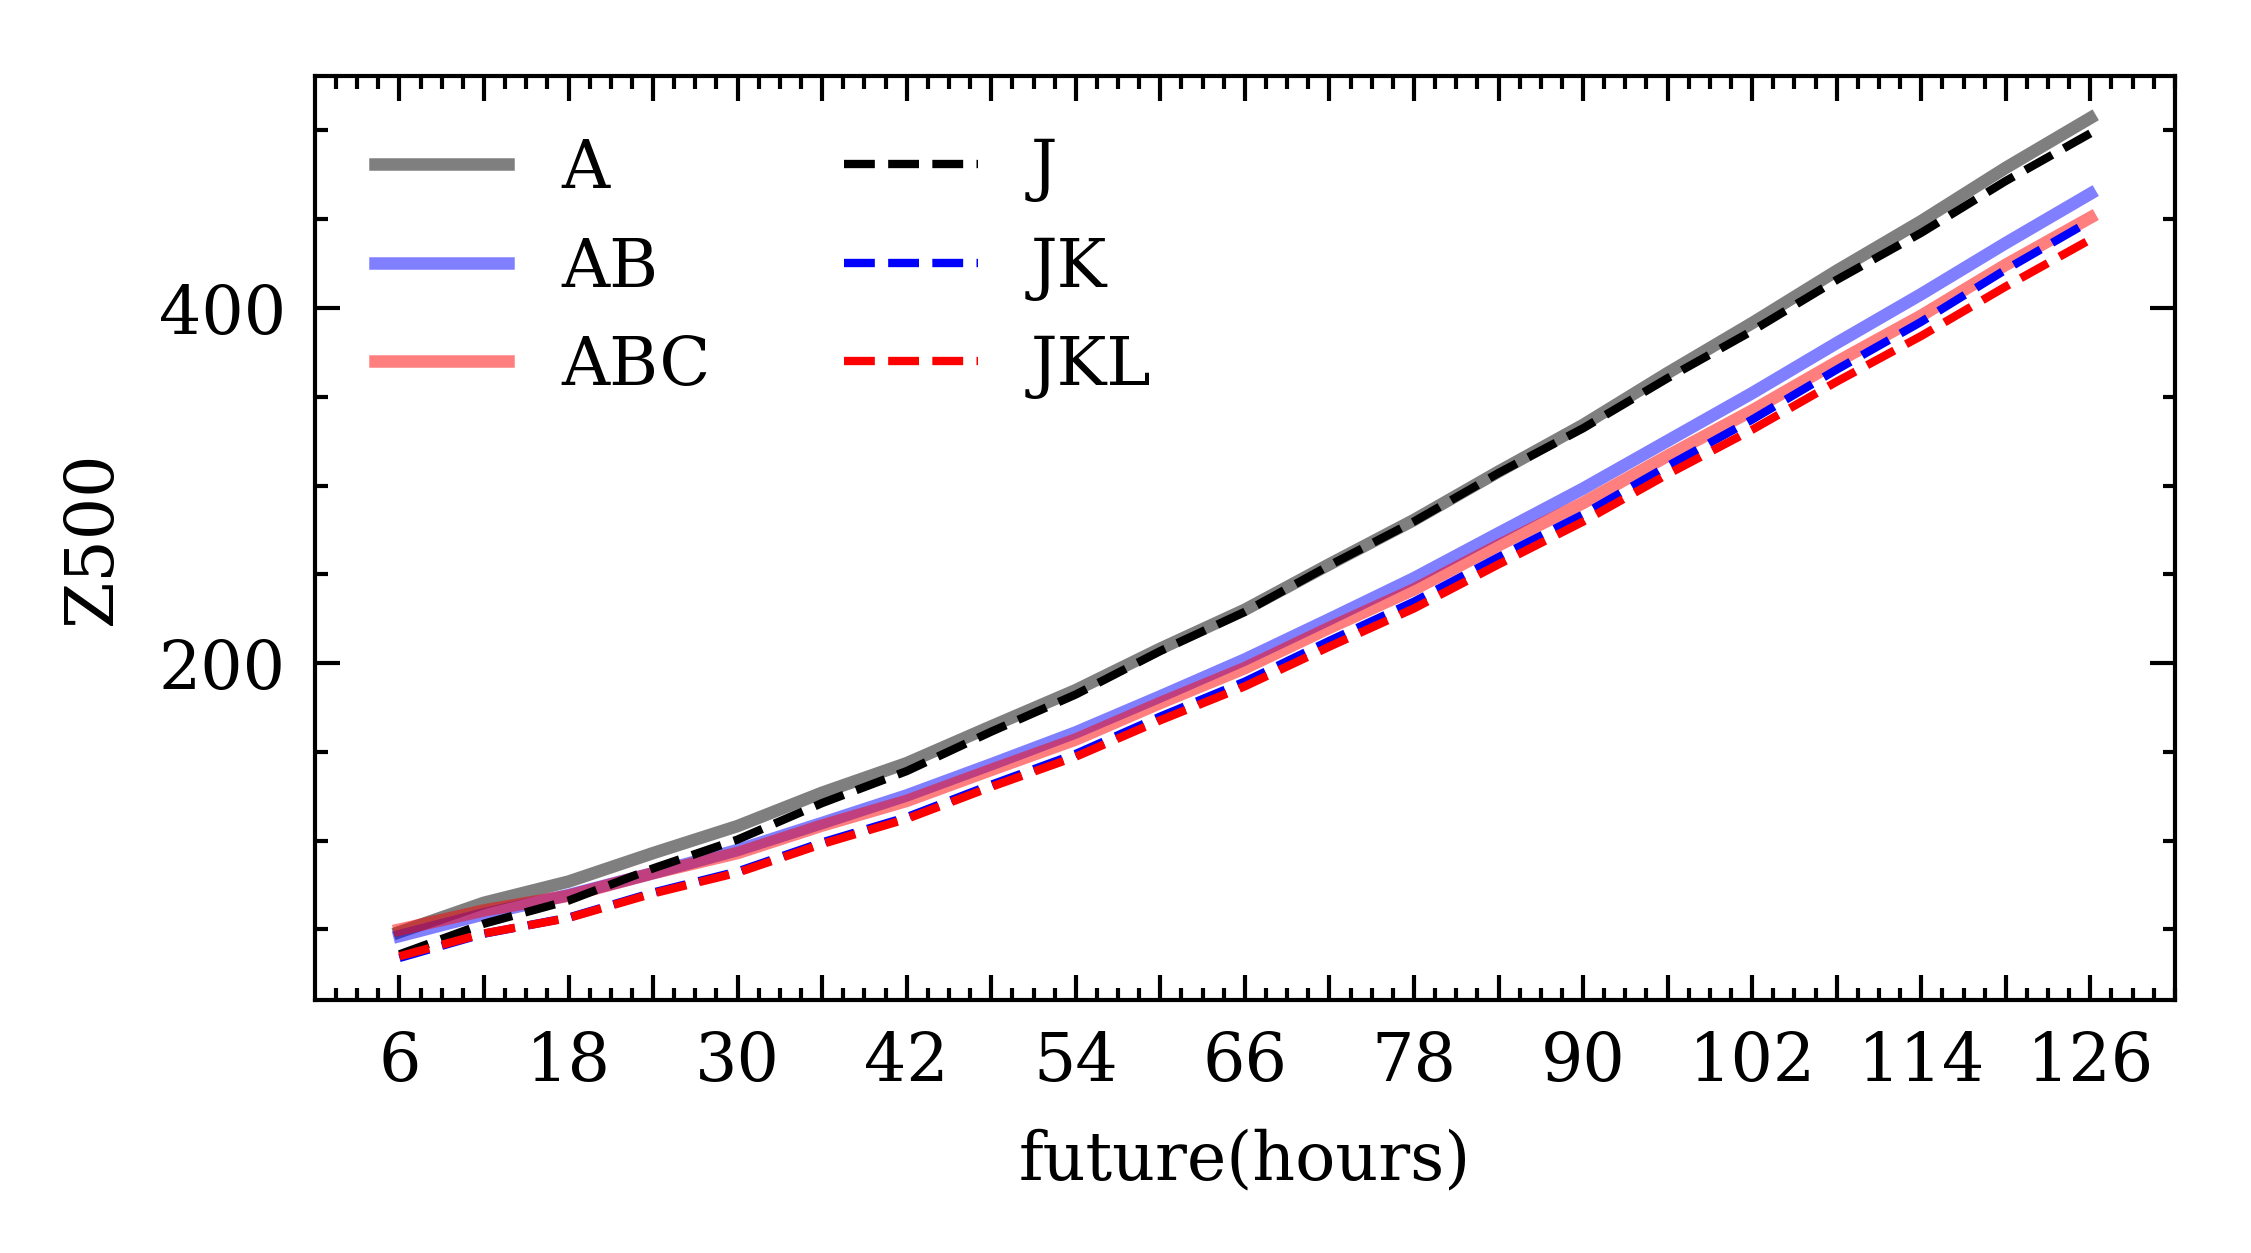

In [54]:
%matplotlib inline
colorlist=['black','b','r','black','b','r']
linestyle_list = ['-','-','-','--','--','--']
xticks   = [str(6*t) if t%2==1  else "" for t in np.arange(1,22) ]
linethickness_list = [1.5]*3+[1]*3
transparency_list  = [0.5]*3+[1]*3
import scienceplots
with plt.style.context(['science', 'no-latex', 'ieee']):
    fig,ax = plt.subplots(figsize=(4,2))
    for i,(nick_name, line) in enumerate(Z500_lines):
        x = [(l[0]+1)*6 for l in line]
        y = [l[1] for l in line]
        ax.plot(x,y,label=nick_name,color=colorlist[i],linestyle=linestyle_list[i],
                linewidth=linethickness_list[i],alpha=transparency_list[i])
    ax.set_xticks(x,xticks,fontsize=8)
    ax.set_xlabel("future(hours)",fontsize=8)
    ax.set_ylabel("Z500",fontsize=8)
    ax.legend(ncol=2)
fig.savefig("figures/Z500_WB3264-60k_showcase.png",dpi=300,bbox_inches='tight')

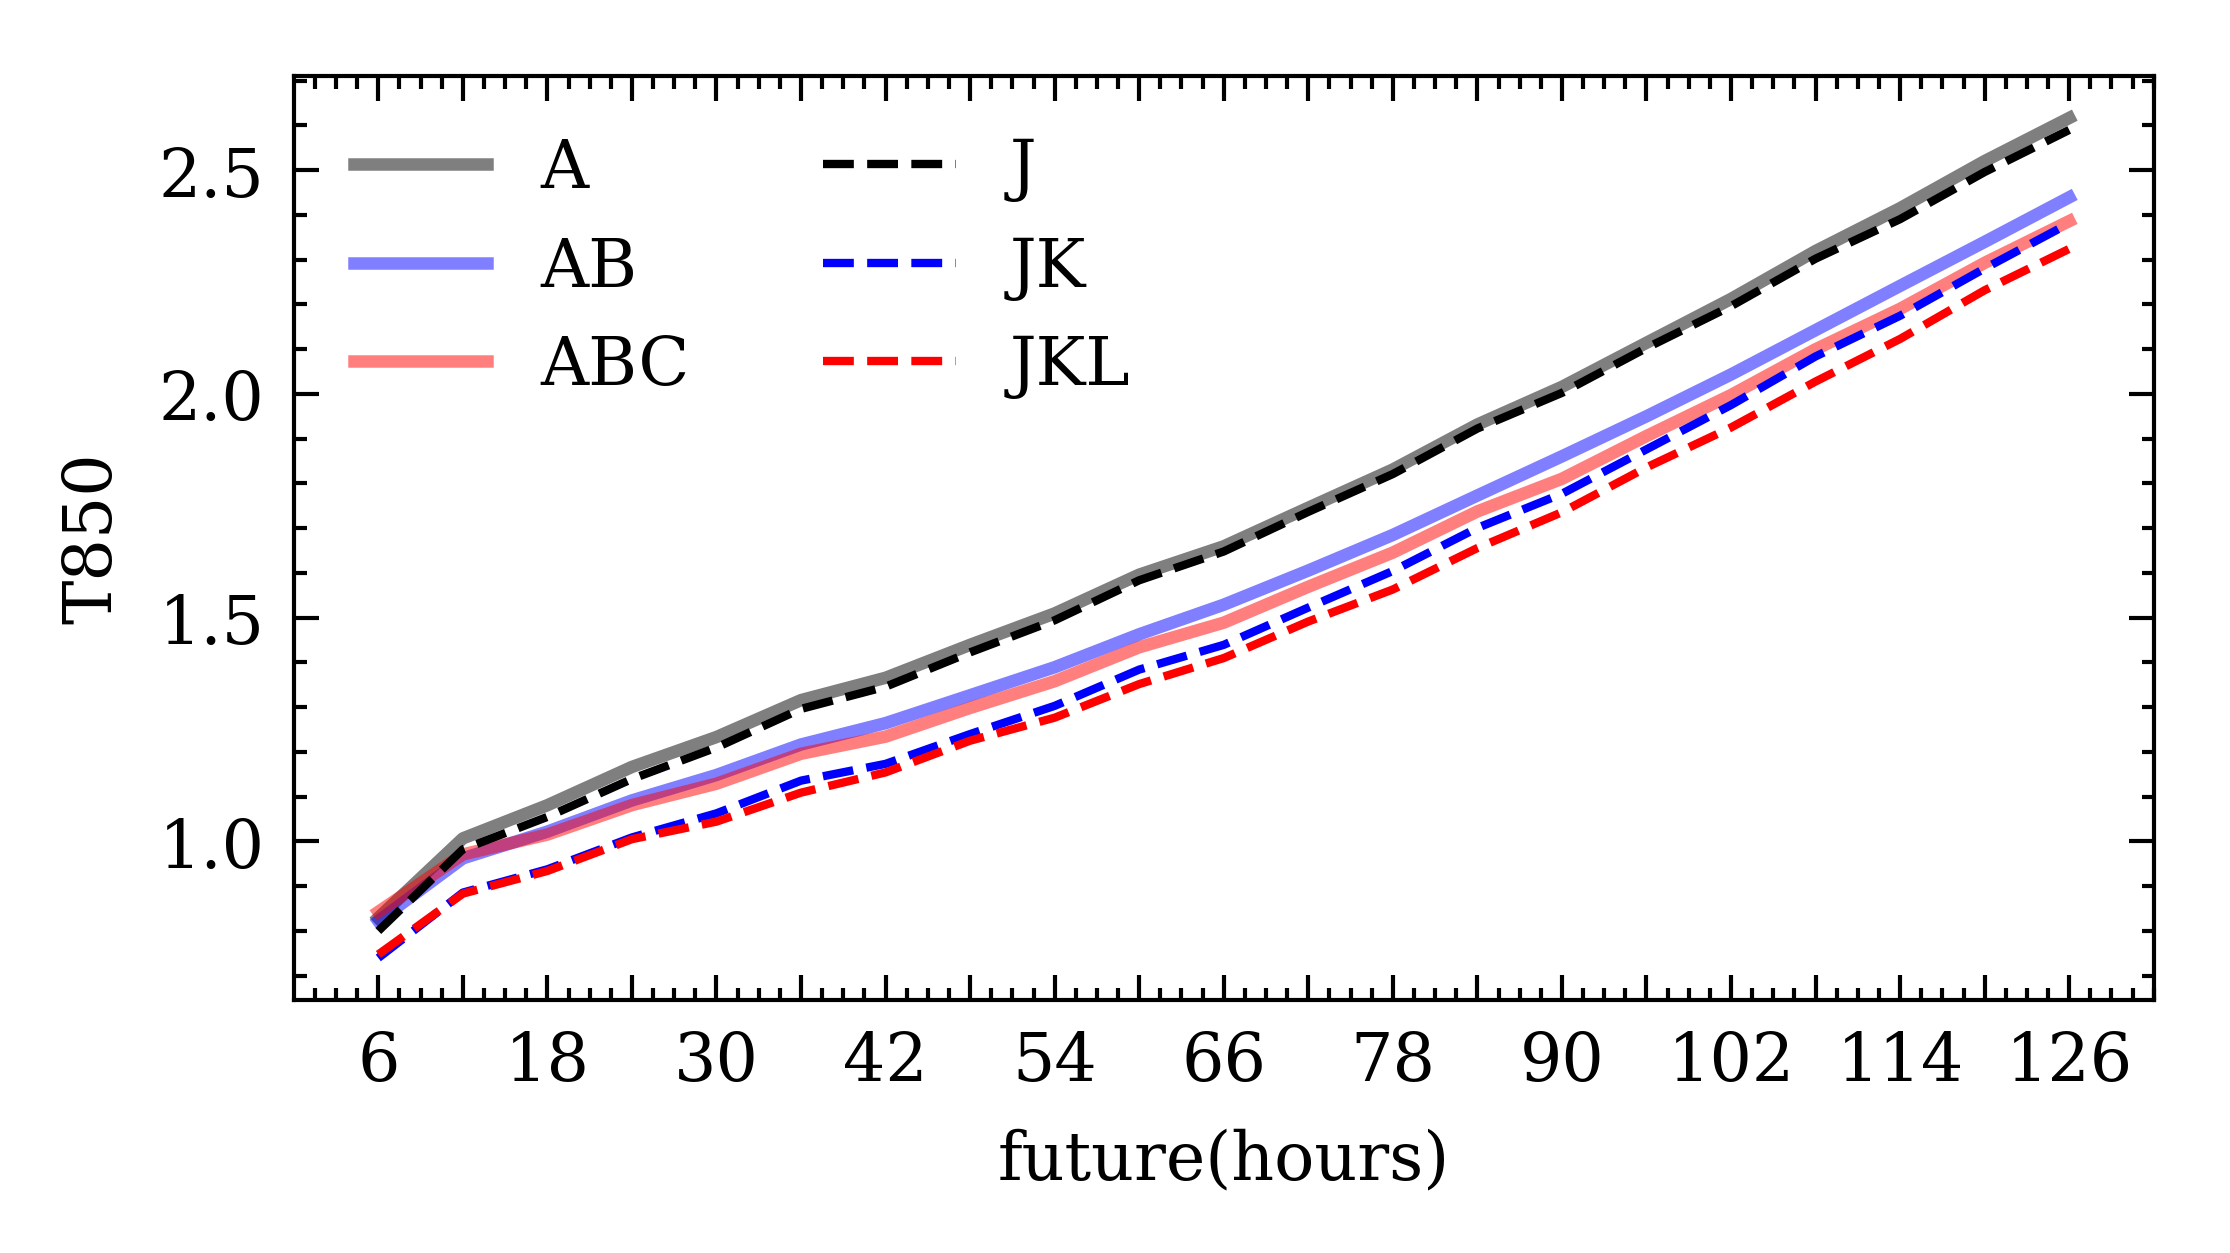

In [53]:
%matplotlib inline
colorlist=['black','b','r','black','b','r']
linestyle_list = ['-','-','-','--','--','--']
xticks   = [str(6*t) if t%2==1  else "" for t in np.arange(1,22) ]
linethickness_list = [1.5]*3+[1]*3
transparency_list  = [0.5]*3+[1]*3
import scienceplots
with plt.style.context(['science', 'no-latex', 'ieee']):
    fig,ax = plt.subplots(figsize=(4,2))
    for i,(nick_name, line) in enumerate(T850_lines):
        x = [(l[0]+1)*6 for l in line]
        y = [l[1] for l in line]
        ax.plot(x,y,label=nick_name,color=colorlist[i],linestyle=linestyle_list[i],
                linewidth=linethickness_list[i],alpha=transparency_list[i])
    ax.set_xticks(x,xticks,fontsize=8)
    ax.set_xlabel("future(hours)",fontsize=8)
    ax.set_ylabel("T850",fontsize=8)
    ax.legend(ncol=2)
fig.savefig("figures/T850_WB3264-60k_showcase.png",dpi=300,bbox_inches='tight')

In [106]:
# %matplotlib inline
# colorlist=['black','g','b','olive','r','purple','magenta','orange']
# import scienceplots
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     fig,ax = plt.subplots(figsize=(5,3))
#     for i,(nick_name, line) in enumerate(T850_lines):
#         x = [(l[0]+1)*6 for l in line]
#         y = [l[1] for l in line]
#         ax.plot(x,y,label=nick_name,color=colorlist[i])
#     ax.set_xticks(x,fontsize=8)
#     ax.set_xlabel("future(hours)",fontsize=8)
#     ax.set_ylabel("T850",fontsize=8)
#     ax.legend()
# fig.savefig("figures/T850_WB3264-60k_showcase.png",dpi=300)

###### see different coef

In [2]:
filted_names = {}
runs = api.runs(path=f"szztn951357/WeathBench7066")
for run in runs:  
    name = run.name
    if run.job_type != "ts_3_finetune-2D706N_per_1_step":continue
    if run.state == 'running':continue
    if run.group != "AFNONet":continue
    if run.config['GDMod_type'] != "off":continue
    if 'vertical_constrain' in run.config and (
        run.config['vertical_constrain'] is not None) and  (run.config['vertical_constrain']!=0):continue
    if "pretrain_weight" not in run.config:continue
    if "consistancy_alpha" not in run.config:continue
    if not run.config["consistancy_alpha"]:continue
    if not ("compute_graph_set" not in run.config or run.config["compute_graph_set"] is None):continue
    if '01_06_18_50-seed_73001' not in run.config['pretrain_weight']:continue
    filted_names[name]=1

In [3]:
filted_runs={}
for run in runs:  
    name = run.name
    if name not in filted_names:continue
    if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
    filted_runs[name]['runs'].append(run)
    filted_runs[name]['config']['time_step'] = run.config['time_step']
    filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
    if run.config['mode'] !="fourcast":filted_runs[name]['config']['mode'] = run.config['mode']
    filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
    if "test_rmse_unit_500hPa_geopotential" in run.summary:
        for row in run.scan_history():
            for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                           ('T850','test_rmse_unit_850hPa_temperature')
                          ]:
                if rn in row:
                    if 'time_step' not in row:continue
                    time_step = row['time_step']
                    rmse = row[rn]
                    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                    if vn not in filted_runs[name]['config'][time_step]:
                        filted_runs[name]['config'][time_step][vn] = rmse
                    else:
                        before_rmse = filted_runs[name]['config'][time_step][vn]
                        if before_rmse!=rmse:
                            print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")

inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-0.958-for-0.958
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-58.494-for-58.490
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-1.015-for-1.015
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-69.239-for-69.229
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-1.085-for-1.085
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-81.524-for-81.524
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-1.140-for-1.140
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-94.676-for-94.670
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-1.209-for-1.210
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-109.930-for-109.930
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-1.255-for-1.255
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-125.528-for-125.526
inconsistancy at run:01_26_17_38_64254-seed_73001-1dyfs74l-1.320-for-1.320
inconsist

inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-0.862-for-0.865
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-46.104-for-46.083
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-0.999-for-0.975
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-60.400-for-58.942
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-1.054-for-1.027
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-71.205-for-68.846
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-1.123-for-1.080
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-86.871-for-82.158
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-1.163-for-1.130
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-100.048-for-94.360
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-1.225-for-1.190
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-117.393-for-110.192
inconsistancy at run:01_29_19_01_64255-seed_73001-1zajrum3-1.269-for-1.222
inconsista

In [4]:
filted_runs['01_26_17_38_64254-seed_73001']['config']['time_step']=3
filted_runs['01_26_17_38_64254-seed_73001']['config']['mode']="finetune"

In [5]:
table_data  = []
repeat_pool = {}
for name, val in filted_runs.items():
    config = val['config']
    if 'consistancy_alpha' not in config:continue
    if 'consistancy_cut_grad' in val['runs'][0].config and val['runs'][0].config['consistancy_cut_grad'] == 1:continue # extra filter
    if 'skip_constant_2D70N' in val['runs'][0].config and val['runs'][0].config['skip_constant_2D70N'] == 1:continue # extra filter
    if val['runs'][0].name in ['02_13_16_49_3718-seed_73001',
                               "01_29_15_23_64252-seed_73001",
                               '02_06_05_44_52597-seed_73001']:continue
    real_continue = False
    for run in val['runs']:
        bs = run.config['real_batch_size']
        bss= run.config['batch_size']
        gpu= run.config['ngpus_per_node']
        mode= run.config['mode']
        if bs != 64 and mode != 'fourcast':
            print(f"{run.name}:{mode}-> bs:{bs}={bss}x{gpu}")
            real_continue = True
    if real_continue:continue

    D1T850 = D1Z500 = D3T850 = D3Z500 = D5T850 = D5Z500 = -1
    if 'mode' not in config:
        #print(val['runs'][0].name)
        continue
    if config['time_step']>4:
        print(val['runs'][0].name)
        continue
    if 11 in config:
        D3T850 = config[11]['T850']
        D3Z500 = config[11]['Z500']
    if 3 in config:
        D1T850 = config[3]['T850']
        D1Z500 = config[3]['Z500']
    if 19 in config:
        D5T850 = config[19]['T850']
        D5Z500 = config[19]['Z500']
    #if 'consistancy_alpha' in config:
    #select_alpha=['1,0', 'eval', '1,0,1', '0,0,1', '1,0,0', '1,0,1,0,0,0']
    #if config['consistancy_alpha'] not in select_alpha:
    #    if config['consistancy_alpha'] not in alpha_map[config['time_step']]:print(config['consistancy_alpha'])
    #    continue
    alpha_show_name=config['consistancy_alpha']

    if config['mode'] =='pretrain' and config['time_step']>2: continue
    if D1T850 == -1:continue
    if config['mode'] !='finetune':
        print(val['runs'][0].name)
        print(config['mode'])
        continue
    time_step_name = f"P:T+{config['time_step']-1}" 
    name = val['runs'][0].name
    mode = config['mode']
    
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 3','T850',D3T850]) 
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 3','Z500',D3Z500])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 1','T850',D1T850])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 1','Z500',D1Z500])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 5','T850',D5T850])
    table_data.append([name,mode,time_step_name,alpha_show_name,'Day 5','Z500',D5Z500])
    setting = f"{config['mode']}{config['time_step']}-{alpha_show_name}"
    if setting not in repeat_pool:repeat_pool[setting]=[]
    repeat_pool[setting].append(val['runs'][0].name)

In [11]:
import pandas as pd

df = pd.DataFrame(table_data, columns=['name','mode', 'time_step', 'rank', 'future', 'metric', 'error'])
df_pivot = df.pivot_table(columns=['metric','future'], index=['rank'], values='error')
#df_pivot = df_pivot.reindex(["S:T+1","P:T+1","P:T+2","P:T+3"], axis=1, level=0)

def apply_border_style(val):
    out = []
    now_state = ""
    out.append('border-left: 2px solid black')
    for i,v in enumerate(val.index[1:-1]):
        if v[0] != now_state and i>0:
            out.append('border-left: 2px solid black')
        else:
            out.append('')
        now_state = v[0]
    out.append('border-right: 2px solid black')
    return out

def apply_compare(val):
    length = len(val)
    group  = {}
    for i,index in enumerate(val.index):
        time_step, rank = index
        v = val[i]
        if time_step not in group:group[time_step]=[]
        group[time_step].append([i,v])
    
    the_min_index = []
    for g, values in group.items():
        the_min_index.append(sorted(values,key=lambda x:x[1])[0][0])
    
    out = []
    for i in range(length):
        out.append("" if i not in the_min_index else 'color: red')
    return out

def apply_under_line_best_inblock(val):
    length = len(val)
    assert length%2 == 0
    out = []
    for A,D in np.split(val,length//2):
        min_index = np.argmin([A,D])
        temp = ["","",""]
        temp[min_index] = 'border-bottom: 3px solid black'
        out.extend(temp)
    return out

def highlight_min(s):
    is_min = s == np.nanmin(s)
    return ['background-color: lightblue' if v else '' for v in is_min]


styled_df = df_pivot.style.format("{:.3g}").apply(highlight_min,axis=0).apply(apply_border_style,axis=1).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
    {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
])


styled_df


In [12]:
"""0,0,1&1.07&1.55&2.26&80.2&220&423\\
0.1,0.1,0.1&1.07&1.55&2.27&79.8&220&425\\
1,0,0&1.08&1.58&2.32&80.8&224&434\\
1,0,1&1.07&1.54&2.27&80.9&222&431\\
1,0.1,0.1&1.07&1.55&2.27&80.3&222&427\\
1,1,0&1.08&1.56&2.27&81.5&224&430\\
1,1,1&1.12&1.59&2.29&86.9&233&441\\
1,10,10&1.24&1.64&2.34&97.5&244&459\\
1.5,0,0&1.08&1.58&2.31&81&224&434\\
eval&1.09&1.6&2.34&81.6&225&438\\"""

\begin{table}
\thbold
\th.level03px solid black
\th.level12px solid black
\th.col_heading2px solid black
\tdcenter
\td.col_heading.level02px solid black
\td.row_heading.level12px solid black
\begin{tabular}{lrrrrrr}
metric & \multicolumn{3}{r}{T850} & \multicolumn{3}{r}{Z500} \\
future & Day 1 & Day 3 & Day 5 & Day 1 & Day 3 & Day 5 \\
rank &  &  &  &  &  &  \\
0,0,1 & \border-left2px solid black 1.07 & 1.55 & \background-colorlightblue 2.26 & \border-left2px solid black 80.2 & 220 & \background-colorlightblue \border-right2px solid black 423 \\
0.1,0.1,0.1 & \background-colorlightblue \border-left2px solid black 1.07 & 1.55 & 2.27 & \background-colorlightblue \border-left2px solid black 79.8 & \background-colorlightblue 220 & \border-right2px solid black 425 \\
1,0,0 & \border-left2px solid black 1.08 & 1.58 & 2.32 & \border-left2px solid black 80.8 & 224 & \border-right2px solid black 434 \\
1,0,1 & \border-left2px solid black 1.07 & \background-colorlightblue 1.54 & 2.27 & \border-l

###### see different eps

In [38]:
filted_names = {}
runs = api.runs(path=f"szztn951357/WeathBench7066")
for run in runs:  
    name = run.name
    if run.job_type != "ts_3_finetune-2D706N_per_1_step":continue
    if run.state == 'running':continue
    if run.group != "AFNONet":continue
    if run.config['GDMod_type'] != "off":continue
    if 'vertical_constrain' in run.config and (run.config['vertical_constrain'] is not None) and  (run.config['vertical_constrain']!=0):continue
    if "pretrain_weight" not in run.config:continue
    if "compute_graph_set" not in run.config or run.config["compute_graph_set"] is None:continue
    if "Rog" not in run.config["compute_graph_set"]:continue
    if '01_06_18_50-seed_73001' not in run.config['pretrain_weight']:continue
    filted_names[name]=1
# add eval 
filted_names['02_02_18_52_62389-seed_73001'] = 1

In [39]:
filted_runs={}

In [41]:
for run in runs:  
    name = run.name
    if name not in filted_names:continue
    if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
    filted_runs[name]['runs'].append(run)
    filted_runs[name]['config']['dataset'] = "WeathBench7066"
    filted_runs[name]['config']['model'] = "AFNONet"
    filted_runs[name]['config']['time_step'] = run.config['time_step']
    filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
    if run.config['mode'] not in ["finetune","pretrain"]:filted_runs[name]['config']['mode'] = run.config['mode']
    filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
    if "test_rmse_unit_500hPa_geopotential" in run.summary:
        for row in run.scan_history():
            for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                           ('T850','test_rmse_unit_850hPa_temperature')
                          ]:
                if rn in row:
                    if 'time_step' not in row:continue
                    time_step = row['time_step']
                    rmse = row[rn]
                    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                    if vn not in filted_runs[name]['config'][time_step]:
                        filted_runs[name]['config'][time_step][vn] = rmse
                    else:
                        before_rmse = filted_runs[name]['config'][time_step][vn]
                        if before_rmse!=rmse:
                            print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")

In [42]:
filted_names = {}
runs = api.runs(path=f"szztn951357/WeathBench32x64")
for run in runs:  
    name = run.name
    if run.job_type != "ts_3_finetune-2D706N_per_6_step":continue
    if run.state == 'running':continue
    if run.group != "CK_LgNet":continue
    if run.config['GDMod_type'] != "off":continue
    if 'vertical_constrain' in run.config and (run.config['vertical_constrain'] is not None) and  (run.config['vertical_constrain']!=0):continue
    if "pretrain_weight" not in run.config:continue
    if "compute_graph_set" not in run.config or run.config["compute_graph_set"] is None:continue
    if "2_D" not in run.config["compute_graph_set"]:continue
    if '02_24_09_58_53396' not in run.config['pretrain_weight']:continue
    filted_names[name]=1
# add eval 
filted_names['02_24_18_00_54553-seed_73001'] = 1

In [43]:
for run in runs:  
    name = run.name
    if name not in filted_names:continue
    if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
    filted_runs[name]['runs'].append(run)
    filted_runs[name]['config']['dataset'] = "WeathBench32x64"
    filted_runs[name]['config']['model'] = "CK_LgNet"
    filted_runs[name]['config']['time_step'] = run.config['time_step']
    filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
    if run.config['mode'] !="fourcast":filted_runs[name]['config']['mode'] = run.config['mode']
    filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
    if "test_rmse_unit_500hPa_geopotential" in run.summary:
        for row in run.scan_history():
            for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                           ('T850','test_rmse_unit_850hPa_temperature')
                          ]:
                if rn in row:
                    if 'time_step' not in row:continue
                    time_step = row['time_step']
                    rmse = row[rn]
                    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                    if vn not in filted_runs[name]['config'][time_step]:
                        filted_runs[name]['config'][time_step][vn] = rmse
                    else:
                        before_rmse = filted_runs[name]['config'][time_step][vn]
                        if before_rmse!=rmse:
                            print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")

inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-0.649-for-0.659
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-40.452-for-41.621
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-0.743-for-0.741
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-42.814-for-42.679
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-0.816-for-0.825
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-55.516-for-56.578
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-0.864-for-0.863
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-61.436-for-61.510
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-0.928-for-0.936
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-75.108-for-76.108
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-0.974-for-0.974
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-84.217-for-84.420
inconsistancy at run:02_25_16_53_39892-seed_73001-2o6u0ddx-1.037-for-1.043
inconsistancy

In [44]:
filted_runs['03_08_22_12_33056-seed_73001']={
  'config': {'dataset': 'WeathBench32x64',
  'model': 'CK_LgNet',
  'time_step': 3,
  'compute_graph_set': 'fwd2_D_Rog5',
  'consistancy_alpha': None,
   0: {'T850': 0.624318302,'Z500': 29.60892296},
   1: {'T850': 0.726119518,'Z500': 38.06017685},
   2: {'T850': 0.79351604,'Z500': 50.47886276},
   3: {'T850': 0.849171877,'Z500': 60.07801056},
   4: {'T850': 0.905733585,'Z500': 72.0438385},
   5: {'T850': 0.960660338,'Z500': 83.71723938},
   6: {'T850': 1.016245961,'Z500': 96.55443573},
   7: {'T850': 1.074061275,'Z500': 110.2935257},
   8: {'T850': 1.134914279,'Z500': 125.2653961},
   9: {'T850': 1.19953239,'Z500': 141.3131866},
  10: {'T850': 1.267264247,'Z500': 158.4923553},
  11: {'T850': 1.339838028,'Z500': 176.7962799},
  12: {'T850': 1.416642547,'Z500': 196.2006683},
  13: {'T850': 1.496783733,'Z500': 216.710556},
  14: {'T850': 1.581108332,'Z500': 238.3775787},
  15: {'T850': 1.669597864,'Z500': 261.168457},
  16: {'T850': 1.761876464,'Z500': 285.0789185},
  17: {'T850': 1.856951237,'Z500': 309.8445129},
  18: {'T850': 1.954890966,'Z500': 335.3869019},
  19: {'T850': 2.054151773,'Z500': 361.4940491},
  20: {'T850': 2.154876947,'Z500': 388.0979004},
  'mode': 'finetune'},
  'runs':[api.run(path=f"szztn951357/WeathBench32x64/runs/20wt3pq5")]
}

In [49]:
table_data  = []
repeat_pool = {}
for name, val in filted_runs.items():
    config = val['config']
    if 'consistancy_alpha' not in config:continue
    if 'consistancy_cut_grad' in val['runs'][0].config and val['runs'][0].config['consistancy_cut_grad'] == 1:continue # extra filter
    if 'skip_constant_2D70N' in val['runs'][0].config and val['runs'][0].config['skip_constant_2D70N'] == 1:continue # extra filter
    real_continue = False
    for run in val['runs']:
        bs = run.config['real_batch_size']
        bss= run.config['batch_size']
        gpu= run.config['ngpus_per_node']
        mode= run.config['mode']
        if bs != 64 and mode != 'fourcast':
            print(f"{run.name}:{mode}-> bs:{bs}={bss}x{gpu}")
            real_continue = True
    #if real_continue:continue

    D1T850 = D1Z500 = D3T850 = D3Z500 = D5T850 = D5Z500 = -1
    if 'mode' not in config:
        #print(val['runs'][0].name)
        continue
    if config['time_step']>4:
        print(val['runs'][0].name)
        continue
    if 11 in config:
        D3T850 = config[11]['T850']
        D3Z500 = config[11]['Z500']
    if 3 in config:
        D1T850 = config[3]['T850']
        D1Z500 = config[3]['Z500']
    if 19 in config:
        D5T850 = config[19]['T850']
        D5Z500 = config[19]['Z500']
    #if 'consistancy_alpha' in config:
    #select_alpha=['1,0', 'eval', '1,0,1', '0,0,1', '1,0,0', '1,0,1,0,0,0']
    #if config['consistancy_alpha'] not in select_alpha:
    #    if config['consistancy_alpha'] not in alpha_map[config['time_step']]:print(config['consistancy_alpha'])
    #    continue
    set_map = {'fwd2_D_Rog2':"L:1e-2",
               'fwd2_D_Rog3':"L:1e-3",
               'fwd2_D_Rog5':"L:1e-5",
               'fwd2_D_Log':"L:1",
               "fwd2_D":"MSE"}
    if config['compute_graph_set'] is None:
        print(name)
        print(config['compute_graph_set'])
        config['compute_graph_set'] = "fwd2_D"
    alpha_show_name=set_map[config['compute_graph_set']]

    if config['mode'] =='pretrain' and config['time_step']>2: continue
    if D1T850 == -1:continue
    if config['mode'] !='finetune':
        print(val['runs'][0].name)
        print(config['mode'])
        continue
    time_step_name = f"P:T+{config['time_step']-1}" 
    name = val['runs'][0].name
    mode = config['mode']
    dataset = config['dataset']
    modelmap={'AFNONet':"AFNONet","CK_LgNet":"LgNet"}
    model = modelmap[config['model']]
    table_data.append([dataset,model,name,mode,time_step_name,alpha_show_name,'Day 3','T850',D3T850]) 
    table_data.append([dataset,model,name,mode,time_step_name,alpha_show_name,'Day 3','Z500',D3Z500])
    table_data.append([dataset,model,name,mode,time_step_name,alpha_show_name,'Day 1','T850',D1T850])
    table_data.append([dataset,model,name,mode,time_step_name,alpha_show_name,'Day 1','Z500',D1Z500])
    table_data.append([dataset,model,name,mode,time_step_name,alpha_show_name,'Day 5','T850',D5T850])
    table_data.append([dataset,model,name,mode,time_step_name,alpha_show_name,'Day 5','Z500',D5Z500])
    setting = f"{config['mode']}{config['time_step']}-{alpha_show_name}"
    if setting not in repeat_pool:repeat_pool[setting]=[]
    repeat_pool[setting].append(val['runs'][0].name)

03_08_22_12_33056-seed_73001:finetune-> bs:16=4x4
02_24_18_00_54553-seed_73001:finetune-> bs:16=2x8
02_24_18_00_54553-seed_73001:finetune-> bs:16=2x8
02_24_18_00_54553-seed_73001:finetune-> bs:16=2x8
03_21_05_33_38838-seed_73001:finetune-> bs:16=4x4
02_25_16_53_39892-seed_73001:finetune-> bs:16=4x4
03_09_14_39_38420-seed_73001:finetune-> bs:16=4x4
03_09_14_39_38420-seed_73001:finetune-> bs:16=4x4
03_09_14_39_38420-seed_73001:finetune-> bs:16=4x4
03_10_18_59_45137-seed_73001:finetune-> bs:16=4x4


In [56]:
import pandas as pd

df = pd.DataFrame(table_data, columns=['dataset','model', 'name','mode', 'time_step', 'rank', 'future', 'metric', 'error'])
df_pivot = df.pivot_table(columns=['model','rank'], index=['metric','future'], values='error')
#df_pivot = df_pivot.reindex(["S:T+1","P:T+1","P:T+2","P:T+3"], axis=1, level=0)

def apply_border_style(val):
    out = []
    now_state = ""
    out.append('border-left: 2px solid black')
    for i,v in enumerate(val.index[1:-1]):
        if v[0] != now_state and i>0:
            out.append('border-left: 2px solid black')
        else:
            out.append('')
        now_state = v[0]
    out.append('border-right: 2px solid black')
    return out

def apply_compare(val):
    length = len(val)
    group  = {}
    for i,index in enumerate(val.index):
        time_step, rank = index
        v = val[i]
        if time_step not in group:group[time_step]=[]
        group[time_step].append([i,v])
    
    the_min_index = []
    for g, values in group.items():
        the_min_index.append(sorted(values,key=lambda x:x[1])[0][0])
    
    out = []
    for i in range(length):
        out.append("" if i not in the_min_index else 'color: red')
    return out

def apply_under_line_best_inblock(val):
    length = len(val)
    assert length%2 == 0
    out = []
    for A,D in np.split(val,length//2):
        min_index = np.argmin([A,D])
        temp = ["","",""]
        temp[min_index] = 'border-bottom: 3px solid black'
        out.extend(temp)
    return out

def highlight_min(s):
    is_min = s == np.nanmin(s)
    return ['background-color: lightblue' if v else '' for v in is_min]


styled_df = df_pivot.style.format("{:.3g}").apply(apply_compare,axis=1).apply(apply_border_style,axis=1).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
    {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
])

styled_df

In [60]:
print(styled_df.to_latex())

\begin{table}
\thbold
\th.level03px solid black
\th.level12px solid black
\th.col_heading2px solid black
\tdcenter
\td.col_heading.level02px solid black
\td.row_heading.level12px solid black
\begin{tabular}{llrrrrrrrrr}
 & model & \multicolumn{4}{r}{AFNONet} & \multicolumn{5}{r}{LgNet} \\
 & rank & L:1e-2 & L:1e-3 & L:1e-5 & MSE & L:1 & L:1e-2 & L:1e-3 & L:1e-5 & MSE \\
metric & future &  &  &  &  &  &  &  &  &  \\
\multirow[c]{3}{*}{T850} & Day 1 & \border-left2px solid black 0.992 & \colorred 0.991 & 1.01 & 1.08 & \border-left2px solid black 0.864 & \colorred 0.832 & 0.836 & 0.849 & \border-right2px solid black 0.882 \\
 & Day 3 & \colorred \border-left2px solid black 1.49 & 1.5 & 1.52 & 1.6 & \border-left2px solid black 1.35 & \colorred 1.31 & 1.31 & 1.34 & \border-right2px solid black 1.38 \\
 & Day 5 & \colorred \border-left2px solid black 2.25 & 2.25 & 2.28 & 2.34 & \border-left2px solid black 2.06 & \colorred 2.02 & 2.03 & 2.05 & \border-right2px solid black 2.11 \\
\multirow[c]

In [14]:
def align_columns(latex_table):
    # Split table into lines
    lines = latex_table.split('\n')
     
    # Find the maximum number of columns
    max_cols = 0
    for line in lines:
        cols = line.count('&') + 1
        if cols > max_cols:
            max_cols = cols
     
    # Pad each row with empty cells to the right
    for i in range(len(lines)):
        cols = lines[i].count('&') + 1
        diff = max_cols - cols
        if diff > 0:
            lines[i] = lines[i].rstrip() + ' & ' * diff + '\\\\'
     
    # Reconstruct the table
    return '\n'.join(lines)

###### weatherbench32x64

we directly pick out all trail needed

In [68]:
  
def read_from_name(filted_runs,run, filted_names):
    name = run.name
    if name not in filted_names:return
    if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
        
    filted_runs[name]['runs'].append(run)
    filted_runs[name]['config']['time_step'] = run.config['time_step']
    filted_runs[name]['config']['project'] = run.project
    filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
    if run.config['mode'] !="fourcast":filted_runs[name]['config']['mode'] = run.config['mode']
    filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
    if "test_rmse_unit_500hPa_geopotential" in run.summary:
        for row in run.scan_history():
            for vn, rn in [('Z500','test_rmse_unit_500hPa_geopotential'),
                           ('T850','test_rmse_unit_850hPa_temperature')
                          ]:
                if rn in row:
                    if 'time_step' not in row:return
                    time_step = row['time_step']
                    rmse = row[rn]
                    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
                    if vn not in filted_runs[name]['config'][time_step]:
                        filted_runs[name]['config'][time_step][vn] = rmse
                    else:
                        before_rmse = filted_runs[name]['config'][time_step][vn]
                        if before_rmse!=rmse:
                            print(f"inconsistancy at run:{run.name}-{run.id}-{before_rmse:.3f}-for-{rmse:.3f}")
    return filted_runs

In [150]:
filted_names = ["04_04_20_22_40592-seed_73001","02_19_19_52_52656-seed_73001","04_04_20_17_43621-seed_73001",
"02_24_09_58_53396-seed_73001","02_24_18_00_54553-seed_73001"];
runs = api.runs(path=f"szztn951357/WeathBench32x64")
filted_runs={}
for run in runs:  
    read_from_name(filted_runs,run, filted_names)

inconsistancy at run:04_04_20_22_40592-seed_73001-1hd1o4fz-0.808-for-0.807
inconsistancy at run:04_04_20_22_40592-seed_73001-1hd1o4fz-46.153-for-46.155
inconsistancy at run:04_04_20_22_40592-seed_73001-1hd1o4fz-0.904-for-0.904
inconsistancy at run:04_04_20_22_40592-seed_73001-1hd1o4fz-54.204-for-54.078
inconsistancy at run:04_04_20_17_43621-seed_73001-2wb7cck1-0.745-for-0.746
inconsistancy at run:04_04_20_17_43621-seed_73001-2wb7cck1-37.299-for-37.396
inconsistancy at run:04_04_20_17_43621-seed_73001-2wb7cck1-0.846-for-0.847
inconsistancy at run:04_04_20_17_43621-seed_73001-2wb7cck1-46.117-for-46.119
inconsistancy at run:02_24_09_58_53396-seed_73001-gs6svnt6-0.652-for-0.653
inconsistancy at run:02_24_09_58_53396-seed_73001-gs6svnt6-34.599-for-34.695
inconsistancy at run:02_24_09_58_53396-seed_73001-gs6svnt6-0.775-for-0.776
inconsistancy at run:02_24_09_58_53396-seed_73001-gs6svnt6-44.450-for-44.513
inconsistancy at run:02_24_09_58_53396-seed_73001-gs6svnt6-0.855-for-0.855
inconsistancy

In [183]:
WB32X64_500k_Rog5_name = name = '03_08_22_12_33056-seed_73001'
run = api.run(path=f"szztn951357/WeathBench32x64/run/32x05es0")
if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
filted_runs[name]['config']['project'] = run.project
filted_runs[name]['runs'].append(run)
filted_runs[name]['config']['time_step'] = run.config['time_step']
filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
filted_runs[name]['config']['mode'] = 'finetune'
filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
time_steps = np.array([6,12,18,24,30,36,42,48,54,60,66,72,78,84,90,96,102,108,114,120,126,132])//6 - 1
Z500s = [29.60892296,38.06017685,50.47886276,60.07801056,72.0438385,83.71723938,96.55443573,110.2935257,125.2653961,141.3131866,158.4923553,176.7962799,196.2006683,216.710556,238.3775787,261.168457,285.0789185,309.8445129,335.3869019,361.4940491,388.0979004,414.98172]
T850s = [0.624318302,0.726119518,0.79351604,0.849171877,0.905733585,0.960660338,1.016245961,1.074061275,1.134914279,1.19953239,1.267264247,1.339838028,1.416642547,1.496783733,1.581108332,1.669597864,1.761876464,1.856951237,1.954890966,2.054151773,2.154876947,2.25683403]

for time_step, Z500, T850 in zip(time_steps,Z500s,T850s):
    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
    filted_runs[name]['config'][time_step]['Z500'] = Z500
    filted_runs[name]['config'][time_step]['T850'] = T850

In [184]:
WB64X128_500k_Rog5_name = name = '03_20_02_59_35157-seed_73001'
run = api.run(path=f"szztn951357/WeathBench64x128/run/cr8m0su8")
if name not in filted_runs:filted_runs[name]={'config':{}, 'runs':[]}
filted_runs[name]['config']['project'] = run.project
filted_runs[name]['runs'].append(run)
filted_runs[name]['config']['time_step'] = run.config['time_step']
filted_runs[name]['config']['compute_graph_set'] = run.config['compute_graph_set'] if 'compute_graph_set' in run.config else 'normal'
filted_runs[name]['config']['mode'] = 'finetune'

filted_runs[name]['config']['consistancy_alpha'] = run.config['consistancy_alpha'] if not run.config['consistancy_eval'] else 'eval'
time_steps = np.array([6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132])//6 - 1
Z500s = [24.477203369140625, 31.027057647705078, 37.666603088378906, 45.17385482788086, 53.8161735534668, 63.38022994995117, 73.69034576416016, 85.13078308105469, 97.656005859375, 111.3053207397461, 126.00320434570312, 141.9231719970703, 159.03323364257812, 177.4658966064453, 197.0707244873047, 217.9475860595703, 239.99282836914062, 263.1846618652344, 287.3429870605469, 312.4742126464844, 338.4400329589844, 365.054443359375]
T850s = [0.47414880990982056, 0.5723146200180054, 0.6411155462265015, 0.7016205191612244, 0.75970059633255, 0.8175111413002014, 0.872929036617279, 0.930559515953064, 0.9895888566970825, 1.052137851715088, 1.1167758703231812, 1.1852641105651855, 1.2570942640304565, 1.3336669206619263, 1.4139862060546875, 1.4987837076187134, 1.5868386030197144, 1.6789697408676147, 1.7737840414047241, 1.872032642364502, 1.9725165367126465, 2.074586868286133]

for time_step, Z500, T850 in zip(time_steps,Z500s,T850s):
    if time_step not in filted_runs[name]['config']:filted_runs[name]['config'][time_step]={}
    filted_runs[name]['config'][time_step]['Z500'] = Z500
    filted_runs[name]['config'][time_step]['T850'] = T850


In [185]:
filted_names = ["03_17_17_36_16948-seed_73001"];
runs = api.runs(path=f"szztn951357/WeathBench64x128")
for run in runs:  
    read_from_name(filted_runs,run, filted_names)

In [186]:
table_data  = []
repeat_pool = {}
for name, val in filted_runs.items():
    
    config = val['config']

    D1T850 = D1Z500 = D3T850 = D3Z500 = D5T850 = D5Z500 = -1
    if 'mode' not in config:
        print(val['runs'][0].name)
        continue
    if config['time_step']>4:
        print(val['runs'][0].name)
        continue
    if 11 in config:
        D3T850 = config[11]['T850']
        D3Z500 = config[11]['Z500']
    if 3 in config:
        D1T850 = config[3]['T850']
        D1Z500 = config[3]['Z500']
    if 19 in config:
        D5T850 = config[19]['T850']
        D5Z500 = config[19]['Z500']
    if 'consistancy_alpha' in config and config['consistancy_alpha']:
        select_alpha=['1,0', 'eval', '1,0,1', '0,0,1', '1,0,0', '1,0,1,0,0,0']
        if config['consistancy_alpha'] not in select_alpha:continue
        alpha_show_name=alpha_map[config['time_step']][config['consistancy_alpha']]
    else:
        if config['compute_graph_set']:
            alpha_show_name= unify_compute_graph_name_simple(config['compute_graph_set'])
        else:
            alpha_show_name= ['A','AB','ABC'][config['time_step']-2]
    if config['mode'] =='pretrain' and config['time_step']>2: continue
    time_step_name = f"P:T+{config['time_step']-1}" if config['mode'] =='finetune' else f"S:T+{config['time_step']-1}"
    name = val['runs'][0].name
    mode = config['mode']
    dataset_name= config['project']
    model_name  = val['runs'][0].config['model_type']
    print(dataset_name)
    table_data.append([dataset_name, name,mode,model_name,time_step_name,alpha_show_name,'Day 3','T850',D3T850]) 
    table_data.append([dataset_name, name,mode,model_name,time_step_name,alpha_show_name,'Day 3','Z500',D3Z500])
    table_data.append([dataset_name, name,mode,model_name,time_step_name,alpha_show_name,'Day 1','T850',D1T850])
    table_data.append([dataset_name, name,mode,model_name,time_step_name,alpha_show_name,'Day 1','Z500',D1Z500])
    table_data.append([dataset_name, name,mode,model_name,time_step_name,alpha_show_name,'Day 5','T850',D5T850])
    table_data.append([dataset_name, name,mode,model_name,time_step_name,alpha_show_name,'Day 5','Z500',D5Z500])
    setting = f"{config['mode']}{config['time_step']}-{alpha_show_name}"
    if setting not in repeat_pool:repeat_pool[setting]=[]
    repeat_pool[setting].append(val['runs'][0].name)

WeathBench32x64
WeathBench32x64
WeathBench32x64
WeathBench32x64
WeathBench32x64
WeathBench64x128
WeathBench32x64
WeathBench64x128


In [115]:
import os,torch

In [5]:
import pandas as pd

df = pd.DataFrame(table_data, columns=['dataset', 'name','mode', 'model','time_step', 'rank', 'future', 'metric', 'error'])
df_pivot = df.pivot_table(columns=['dataset','model','rank'], index=['metric','future'], values='error')

def apply_border_style(val):
    out = []
    now_state = ""
    out.append('border-left: 2px solid black')
    for i,v in enumerate(val.index[1:-1]):
        if v[0] != now_state and i>0:
            out.append('border-left: 2px solid black')
        else:
            out.append('')
        now_state = v[0]
    out.append('border-right: 2px solid black')
    return out

def apply_compare(val):
    length = len(val)
    group  = {}
    for i,index in enumerate(val.index):
        time_step, rank = index
        v = val[i]
        if time_step not in group:group[time_step]=[]
        group[time_step].append([i,v])
    
    the_min_index = []
    for g, values in group.items():
        the_min_index.append(sorted(values,key=lambda x:x[1])[0][0])
    
    out = []
    for i in range(length):
        out.append("" if i not in the_min_index else 'color: red')
    return out

def apply_under_line_best_inblock(val):
    length = len(val)
    assert length%2 == 0
    out = []
    for A,D in np.split(val,length//2):
        min_index = np.argmin([A,D])
        temp = ["","",""]
        temp[min_index] = 'border-bottom: 3px solid black'
        out.extend(temp)
    return out

def highlight_min(s):
    is_min = s == np.nanmin(s)
    return ['background-color: lightblue' if v else '' for v in is_min]
styled_df = df_pivot.style.format("{:.4g}").set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.level0', 'props': [('border-bottom', '3px solid black')]},
    {'selector': 'th.level1', 'props': [('border-bottom', '2px solid black')]},
    {'selector': 'th.col_heading', 'props': [('border-right', '2px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'td.col_heading.level0', 'props': [('border-left', '2px solid black')]},
    {'selector': 'td.row_heading.level1', 'props': [('border-left', '2px solid black')]},
])


styled_df

NameError: name 'table_data' is not defined

In [159]:
df[df['rank']=='JK']

,dataset,name,mode,time_step,rank,future,metric,error
0,WeathBench32x64,04_04_20_17_43621-seed_73001,finetune,P:T+2,JK,Day 3,T850,1.450914
1,WeathBench32x64,04_04_20_17_43621-seed_73001,finetune,P:T+2,JK,Day 3,Z500,196.092697
2,WeathBench32x64,04_04_20_17_43621-seed_73001,finetune,P:T+2,JK,Day 1,T850,0.965842
3,WeathBench32x64,04_04_20_17_43621-seed_73001,finetune,P:T+2,JK,Day 1,Z500,69.633789
4,WeathBench32x64,04_04_20_17_43621-seed_73001,finetune,P:T+2,JK,Day 5,T850,2.229280
5,WeathBench32x64,04_04_20_17_43621-seed_73001,finetune,P:T+2,JK,Day 5,Z500,371.392944


In [90]:
# def get_the_compute_graph_defination_from_online(f):
#     content = f.download(root="temp",replace='True')
#     with open("temp/media/table/multi_epoch_fourcast_rmse_unit_list_24_373cbe7004357cc87c54.table.json",'r') as f:
#         data = json.load(f)
#     df = pd.DataFrame(data['data'], columns=data['columns'])
#     #df[df['epoch']==1][['fourcast','500hPa_geopotential','850hPa_temperature']]
#     return df 

### old M_iteration_method

In [157]:
# # property_index = 3
# # data = D3error[:,property_index]
# # name = D3name[property_index]
# # fig = plt.figure(figsize=(12,24))
# # _=plt.imshow(data)
# # _=plt.xticks(range(len(name)),name,rotation=-90)

# error_propagation_finetune['abc_error'].mean(0)

# error_propagation_pretrain['blevel_v'].mean(dim=(0,2))

# (np.arccos(error_propagation_pretrain['Angle'])/np.pi*180).mean(0)

# error_propagation_pretrain1 = get_error_propagation(fourcastresult_pretrain1)
# error_propagation_pretrain2 = get_error_propagation(fourcastresult_pretrain2)

# error_propagation_finetune1 = get_error_propagation(fourcastresult_finetune1)
# error_propagation_finetune2 = get_error_propagation(fourcastresult_finetune2)

# error_propagation_finetune1['est_error'].mean(0)

# error_propagation_finetune2['est_error'].mean(0)

# error_propagation_finetune1['abs_error'].mean(0)

# error_propagation_finetune2['abs_error'].mean(0)

# error_propagation_pretrain1['abs_error'].mean(0)

# error_propagation_pretrain2['abs_error'].mean(0)

# error_propagation_finetune1['JacobV_N'].mean(0).sqrt()

# error_propagation_finetune2['JacobV_N'].mean(0).sqrt()

# print(error_propagation_pretrain1['JacobVA_N'].mean(0).sqrt())
# print(error_propagation_pretrain2['JacobVA_N'].mean(0).sqrt())
# print(error_propagation_finetune1['JacobVA_N'].mean(0).sqrt())
# print(error_propagation_finetune2['JacobVA_N'].mean(0).sqrt())

# error_propagation_finetune2['JacobVA_N'].mean(0).sqrt()

# error_propagation_pretrain['alevel_v'].mean(0).sqrt()/error_propagation_finetune['blevel_v'].mean(0).sqrt()

# error_propagation_pretrain['Jacobianv'].mean(0)

# error_propagation_finetune['est_error'].mean(0)

# error_propagation_finetune['Jacobianv'].mean(0)

# error_propagation_finetune['est_error'].mean(0)*error_propagation_finetune['blevel_v'].mean(0)[:,None].sqrt()/error_propagation_pretrain['blevel_v'].mean(0)[:,None].sqrt()

# error_propagation_pretrain['blevel_v'].mean(0).sqrt()

# error_propagation_finetune['blevel_v'].mean(0).sqrt()

# x, y  = np.meshgrid(np.arange(7),np.arange(7))
# z = error_propagation_finetune['abs_error'].mean(0).numpy()
# data = np.stack([x,y,z],-1).reshape(-1,3)
# data = data[data[:,2]>0]

# weight = torch.load("checkpoints/WeathBench7066/AFNONet/time_step_2_pretrain-2D706N_every_1_step/10_14_20_18_11-seed_73001/backbone.best.pt", map_location='cpu')

# [k for k in weight['model'] if 'patch_embed.proj' in k]

# error_propagation_finetune['JacobV_N'].mean(0)

# error_propagation_pretrain['Jacobianv'].mean(0)